# Complex model

In [1]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
def average_across_arrays(generated_data):
    return generated_data.mean(dim=0)

def compute_psd(data, fs, nperseg=256, noverlap=None):
    """
    Compute Power Spectral Density (PSD) using the Welch method.

    Parameters:
        data (array): EEG data array with shape (n_channels, n_samples).
        fs (float): Sampling frequency.
        nperseg (int): Length of each segment for PSD estimation.
        noverlap (int): Number of overlapping samples between segments.
    
    Returns:
        freqs (array): Frequency values.
        psd (array): Power Spectral Density values.
    """
    n_channels, n_samples = data.shape
    psd = np.zeros((n_channels, nperseg // 2 + 1))

    for ch_idx in range(n_channels):
        f, Pxx = plt.psd(data[ch_idx], Fs=fs, NFFT=nperseg, noverlap=noverlap)
        # Add a small epsilon to avoid zero values
        psd[ch_idx] = Pxx + 1e-10

    return f, psd


NUM_CHANNELS = 64
SEQUENCE_LENGTH = 9760
LAMBDA_GP = 5

def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Gaussian normal distribution
def sample_normal_distribution(i, j, k):
    mu = 0
    sigma = 0.02
    return torch.Tensor(np.random.normal(mu, sigma, (i, j, k)))

def gradient_penalty(D, real, fake):
    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def plot_everything(generated_data, gen_err, critic_err):
    generated_data = generated_data.detach()
    
    # plotting generated data
    values = generated_data[0, 0, :]
    plt.plot(values.tolist())
    plt.show()

    # plotting PSD
    averaged_data = average_across_arrays(generated_data)
    freqs, psd = compute_psd(averaged_data, 160.0)
    plt.figure(figsize=(10, 6))  # Add this line to create a single figure
    for ch_idx in range(64):
        plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

    # plotting G vs D losses
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(gen_err,label="Generator")
    plt.plot(critic_err,label="Critic")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# start

Epoch 0: Critic error ([1.8264334089185883]) Generator err ([0.03248031064867973])


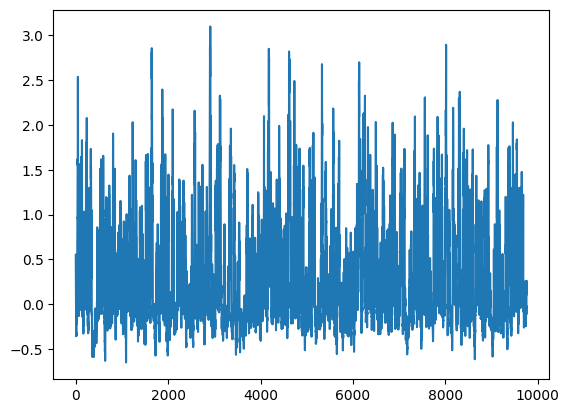

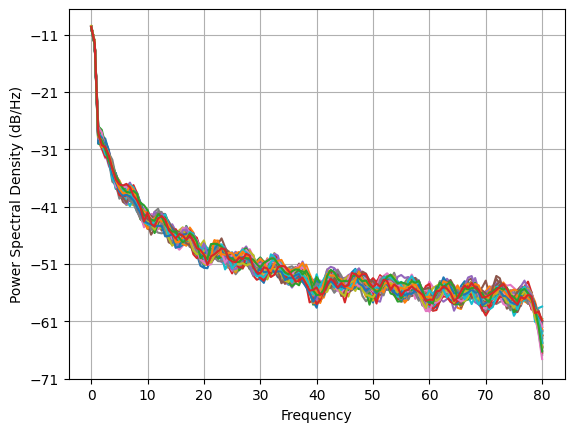

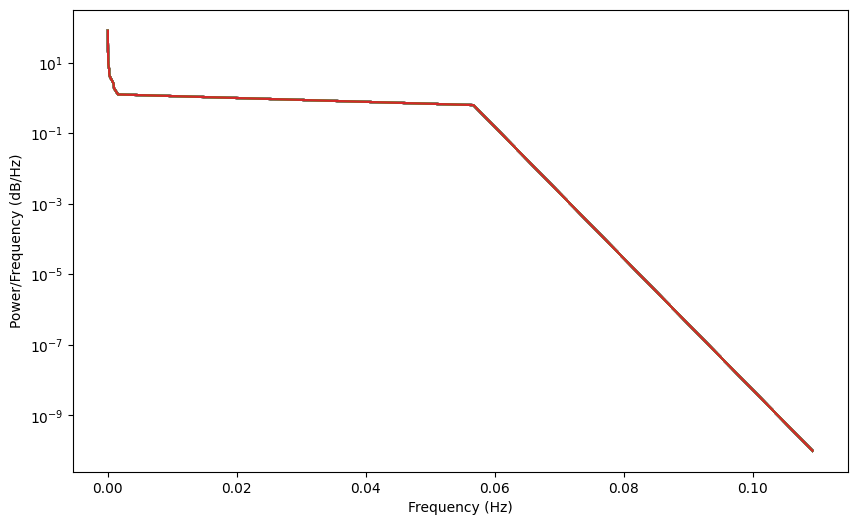

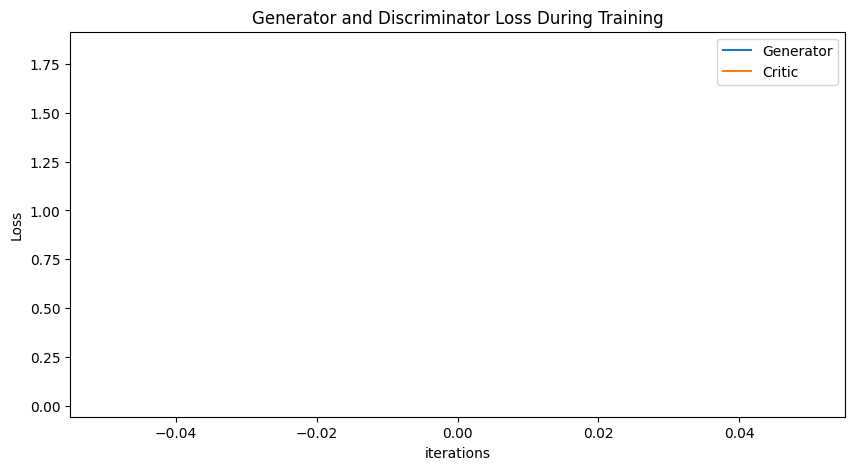

Epoch 10: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099]) Generator err ([0.03248031064867973, 0.010544486343860626, 0.018888967111706734, 0.049192264676094055, 0.11244716495275497, 0.36432573199272156, 0.3154541552066803, 0.39667245745658875, 0.2738531529903412, 0.2566761374473572, 0.22425274550914764])


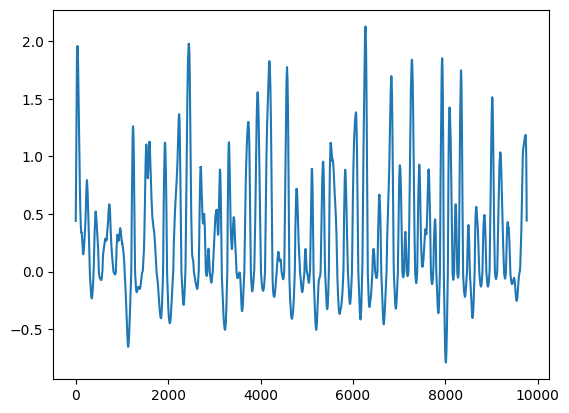

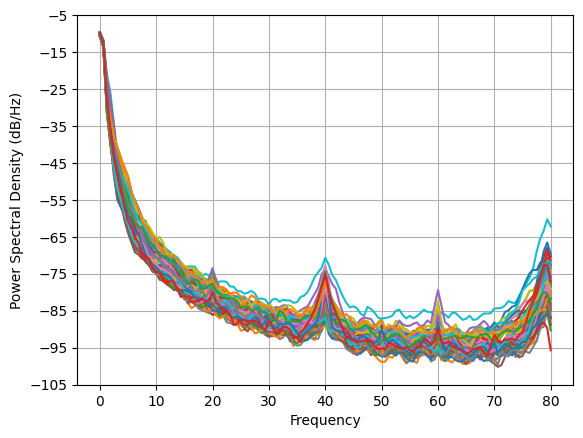

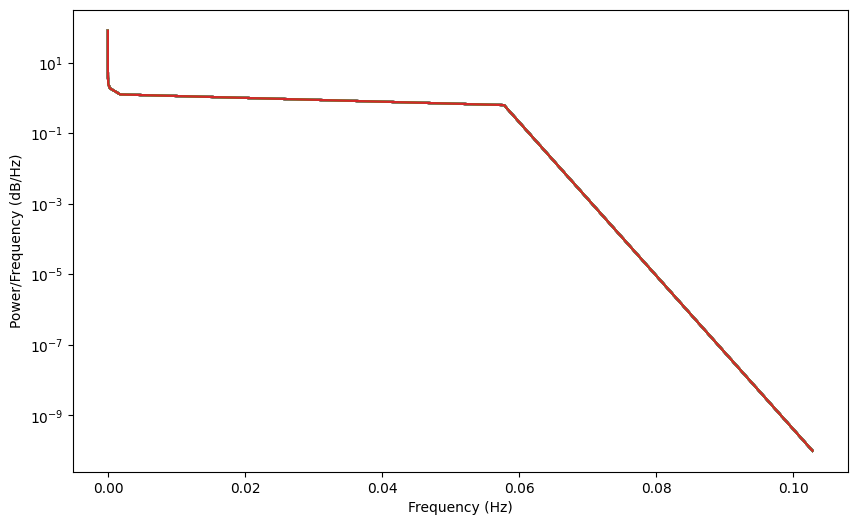

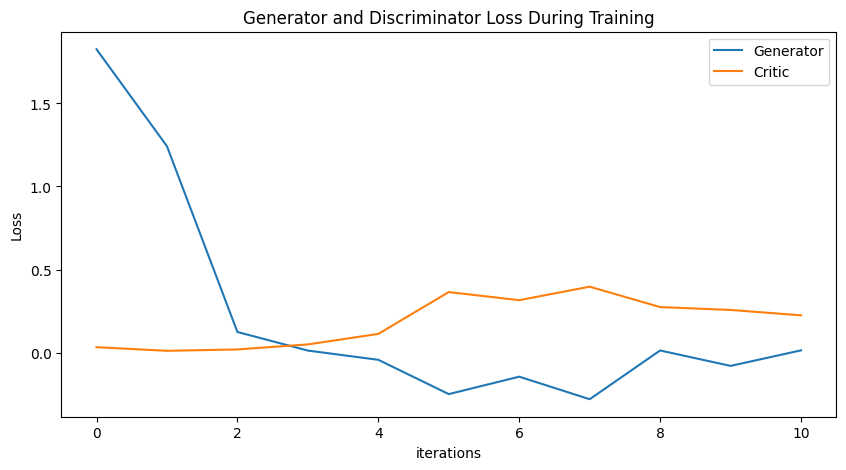

Epoch 20: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099, -0.053555110911149145, -0.1490088985829475, -0.481653089647959, -0.6459408744589094, -0.8110857214240685, -0.8191183042887766, -1.191360196023375, -1.3923246099509072, -1.4939039839104153, -0.9867567959728697]) Generator err ([0.03248031064867973, 0.010544486343860626, 0.018888967111706734, 0.049192264676094055, 0.11244716495275497, 0.36432573199272156, 0.3154541552066803, 0.39667245745658875, 0.2738531529903412, 0.2566761374473572, 0.22425274550914764, 0.25953012704849243, 0.3996976613998413, 0.7165892720222473, 0.8342934846878052, 0.9797831177711487, 1.3363510370254517, 1.3103665113449097, 1.9843136072158813, 1.5057618618011475, 1.4787108898162842])


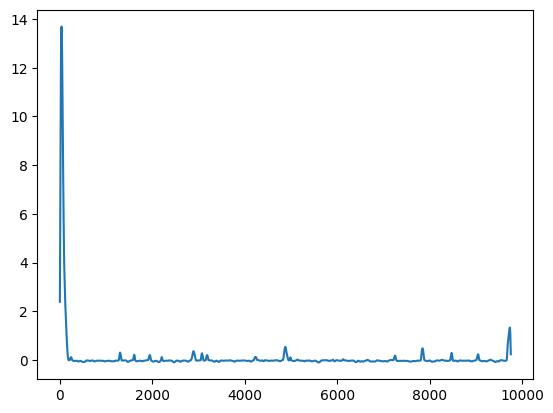

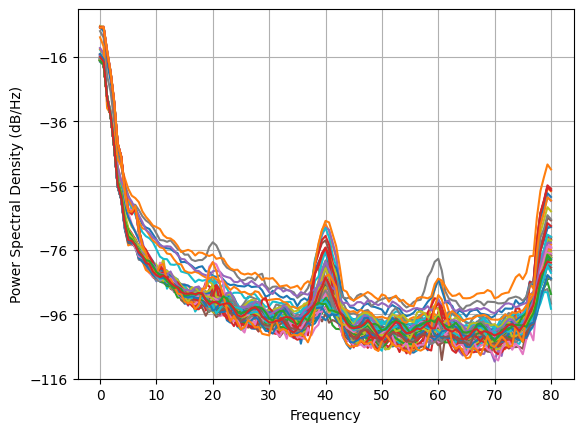

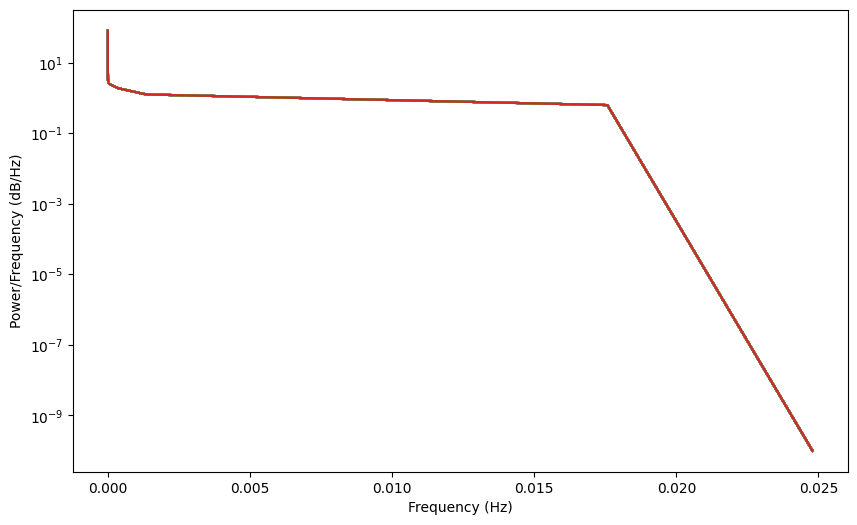

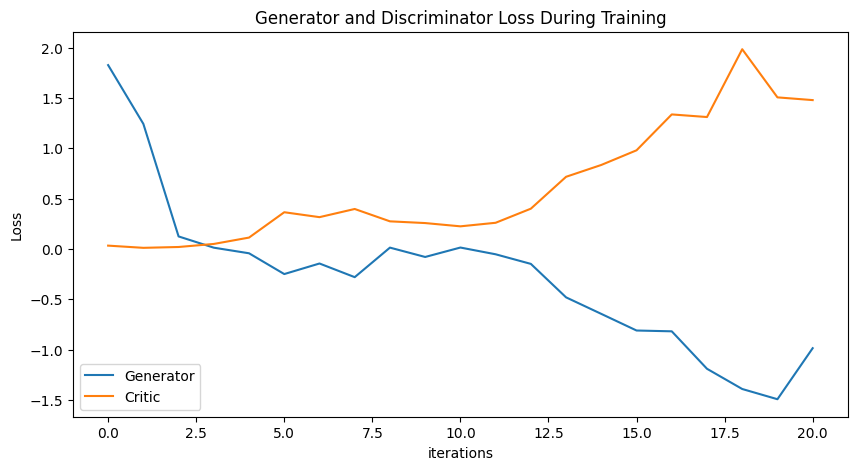

Epoch 30: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099, -0.053555110911149145, -0.1490088985829475, -0.481653089647959, -0.6459408744589094, -0.8110857214240685, -0.8191183042887766, -1.191360196023375, -1.3923246099509072, -1.4939039839104153, -0.9867567959728697, -0.939174374033741, -0.9439010985909159, -1.130508398141421, -1.2797913014053697, -1.8091860329912755, -2.106912181630736, -2.073371218945991, -1.741611448713781, -1.4749941620700076, -1.5638996464619386]) Generator err ([0.03248031064867973, 0.010544486343860626, 0.018888967111706734, 0.049192264676094055, 0.11244716495275497, 0.36432573199272156, 0.3154541552066803, 0.39667245745658875, 0.2738531529903412, 0.2566761374473572, 0.22425274550914764, 0.25953012704849243, 0.3996976613998413, 0.7165892720222473, 0.834293484687805

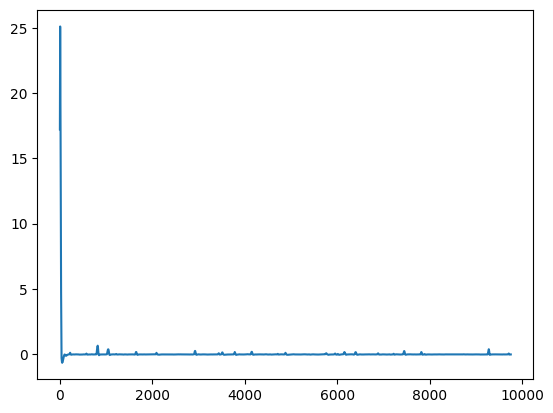

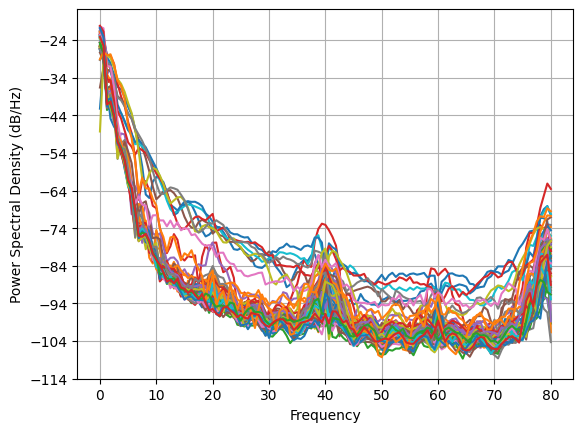

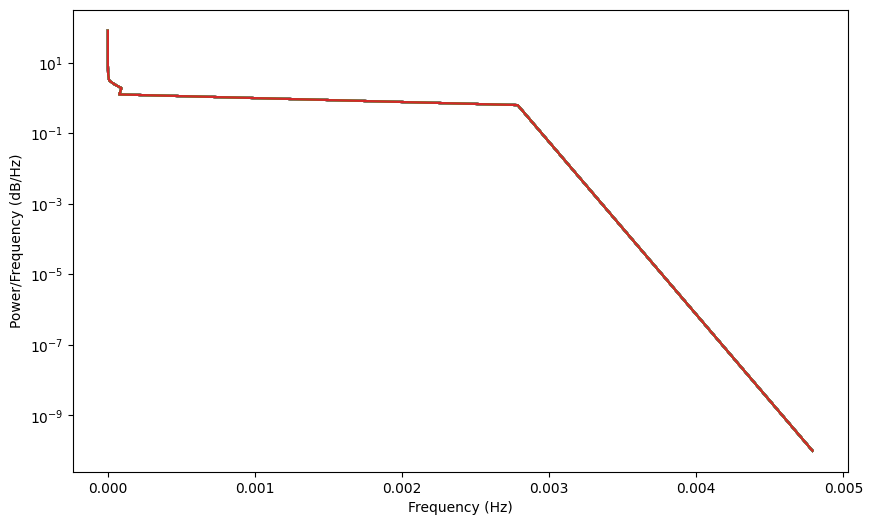

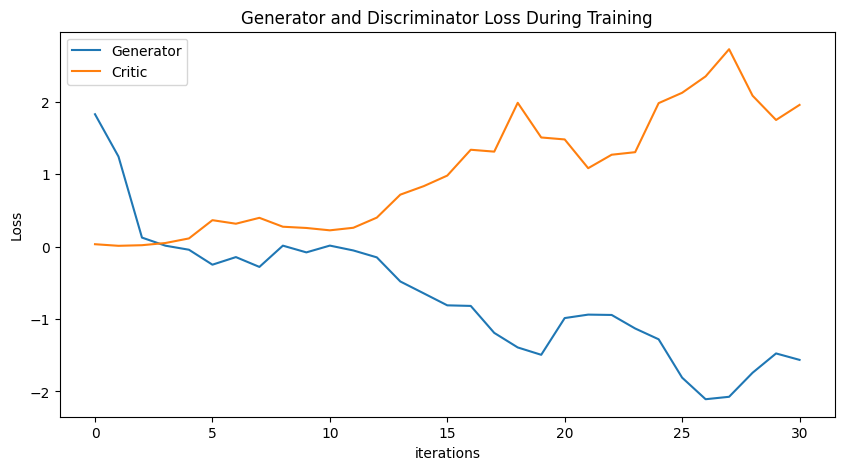

Epoch 40: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099, -0.053555110911149145, -0.1490088985829475, -0.481653089647959, -0.6459408744589094, -0.8110857214240685, -0.8191183042887766, -1.191360196023375, -1.3923246099509072, -1.4939039839104153, -0.9867567959728697, -0.939174374033741, -0.9439010985909159, -1.130508398141421, -1.2797913014053697, -1.8091860329912755, -2.106912181630736, -2.073371218945991, -1.741611448713781, -1.4749941620700076, -1.5638996464619386, -0.8591007689606854, -0.8477450651678754, -0.8787081461593661, -0.9150682154765513, -0.9567433858882582, -0.9079217926209503, -1.0857234871312753, -0.9976619999427864, -1.1894297568119283, -1.0704649147753322]) Generator err ([0.03248031064867973, 0.010544486343860626, 0.018888967111706734, 0.049192264676094055, 0.1124471649

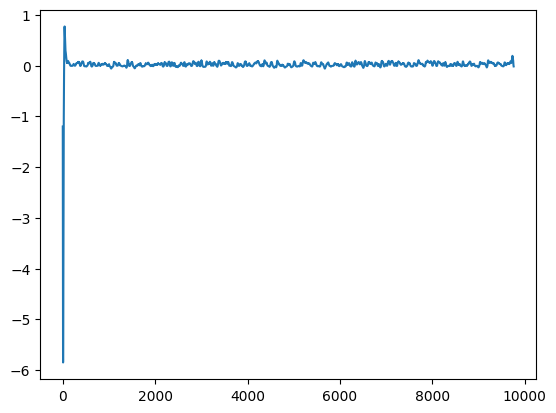

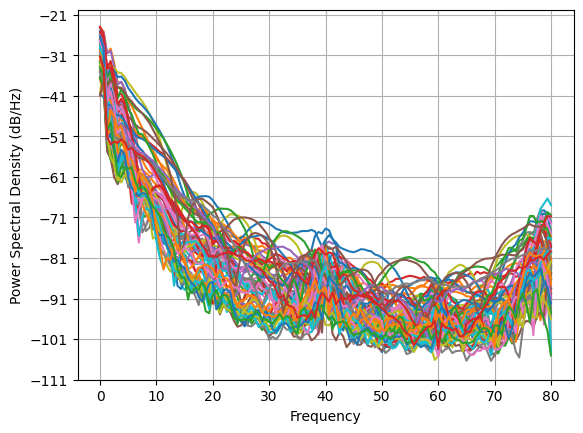

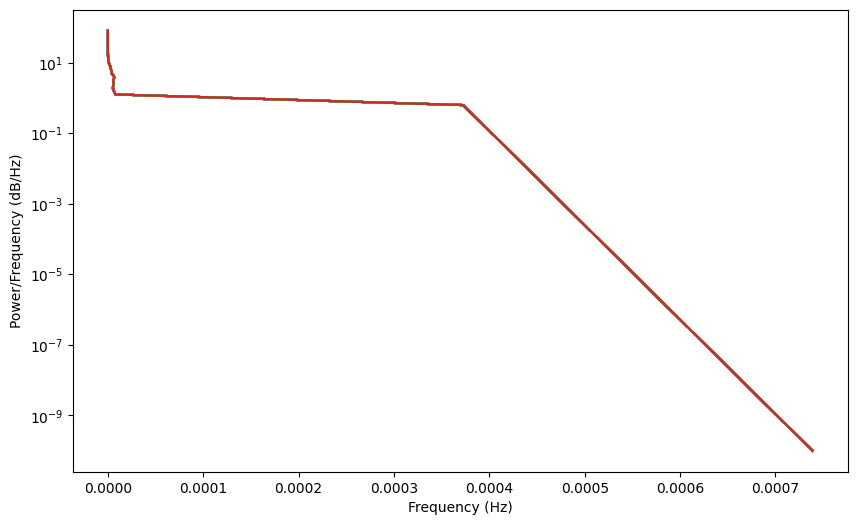

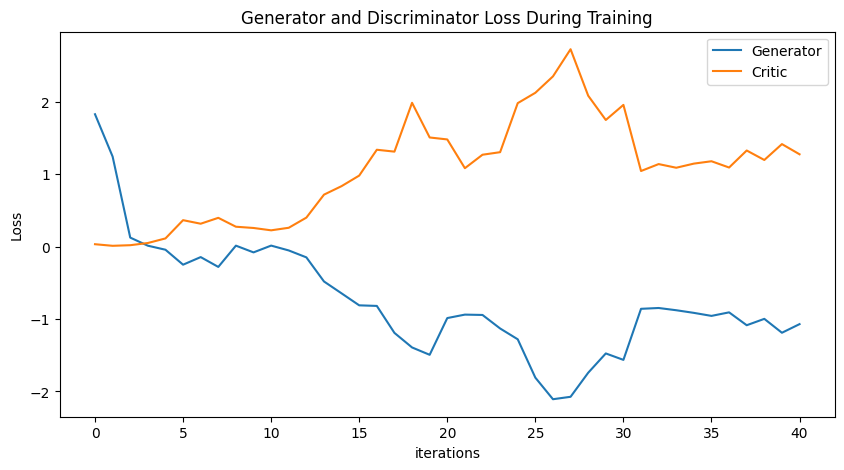

Epoch 50: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099, -0.053555110911149145, -0.1490088985829475, -0.481653089647959, -0.6459408744589094, -0.8110857214240685, -0.8191183042887766, -1.191360196023375, -1.3923246099509072, -1.4939039839104153, -0.9867567959728697, -0.939174374033741, -0.9439010985909159, -1.130508398141421, -1.2797913014053697, -1.8091860329912755, -2.106912181630736, -2.073371218945991, -1.741611448713781, -1.4749941620700076, -1.5638996464619386, -0.8591007689606854, -0.8477450651678754, -0.8787081461593661, -0.9150682154765513, -0.9567433858882582, -0.9079217926209503, -1.0857234871312753, -0.9976619999427864, -1.1894297568119283, -1.0704649147753322, -1.2627880827572628, -1.2160270206575645, -1.3097102167428694, -1.249192655442032, -1.321075664299302, -1.2940571259

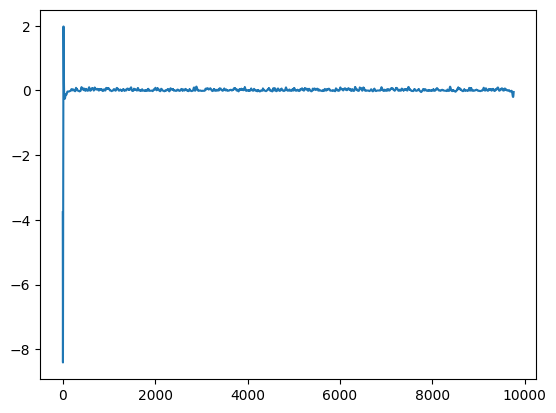

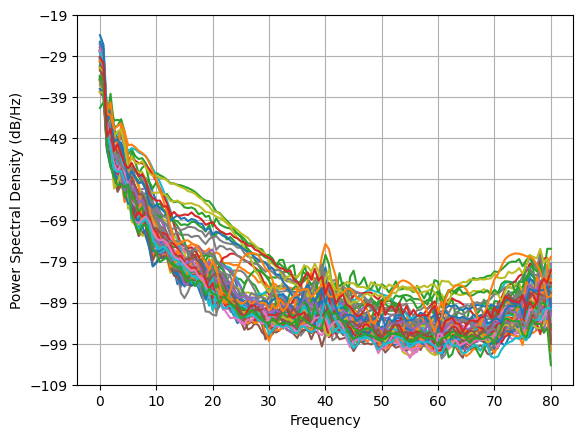

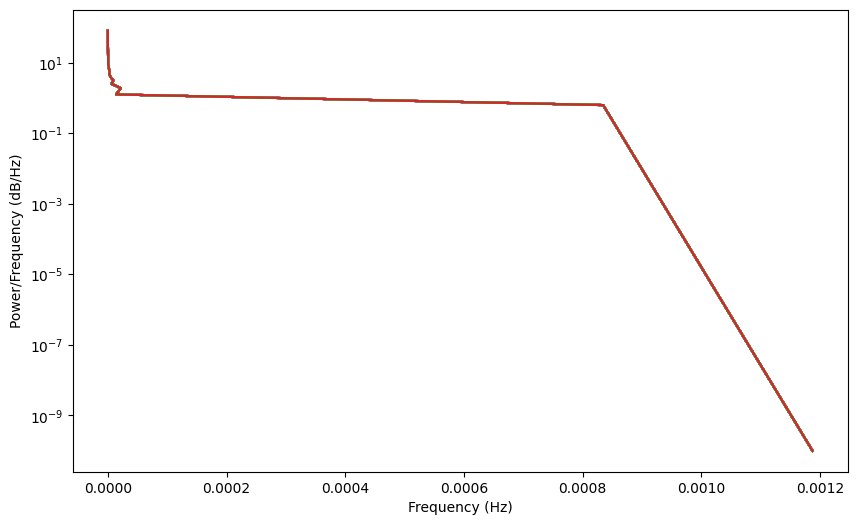

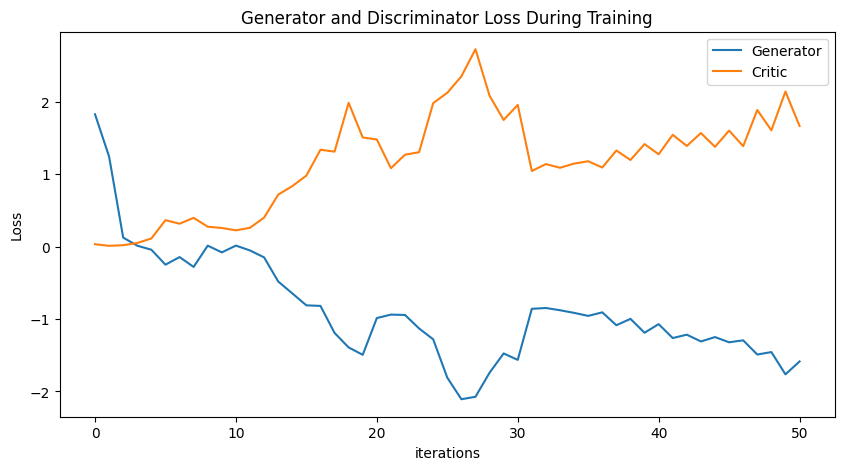

Epoch 60: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099, -0.053555110911149145, -0.1490088985829475, -0.481653089647959, -0.6459408744589094, -0.8110857214240685, -0.8191183042887766, -1.191360196023375, -1.3923246099509072, -1.4939039839104153, -0.9867567959728697, -0.939174374033741, -0.9439010985909159, -1.130508398141421, -1.2797913014053697, -1.8091860329912755, -2.106912181630736, -2.073371218945991, -1.741611448713781, -1.4749941620700076, -1.5638996464619386, -0.8591007689606854, -0.8477450651678754, -0.8787081461593661, -0.9150682154765513, -0.9567433858882582, -0.9079217926209503, -1.0857234871312753, -0.9976619999427864, -1.1894297568119283, -1.0704649147753322, -1.2627880827572628, -1.2160270206575645, -1.3097102167428694, -1.249192655442032, -1.321075664299302, -1.2940571259

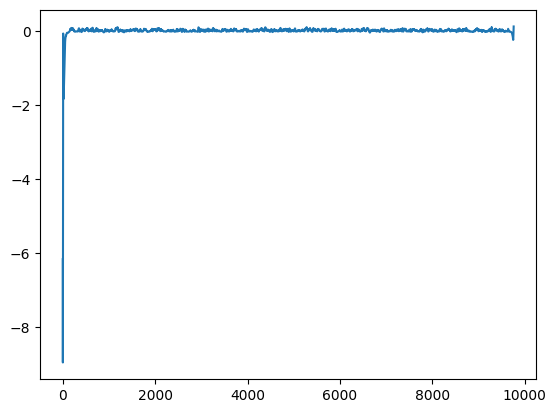

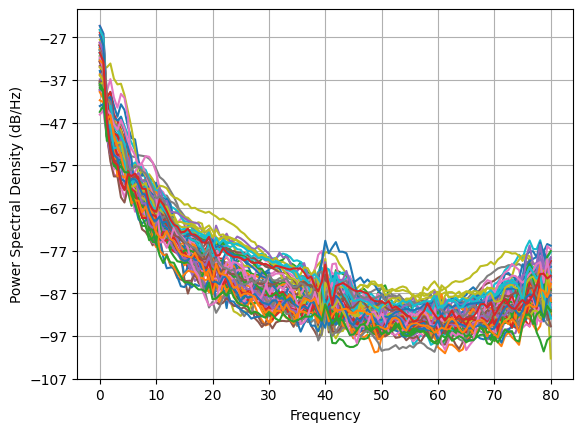

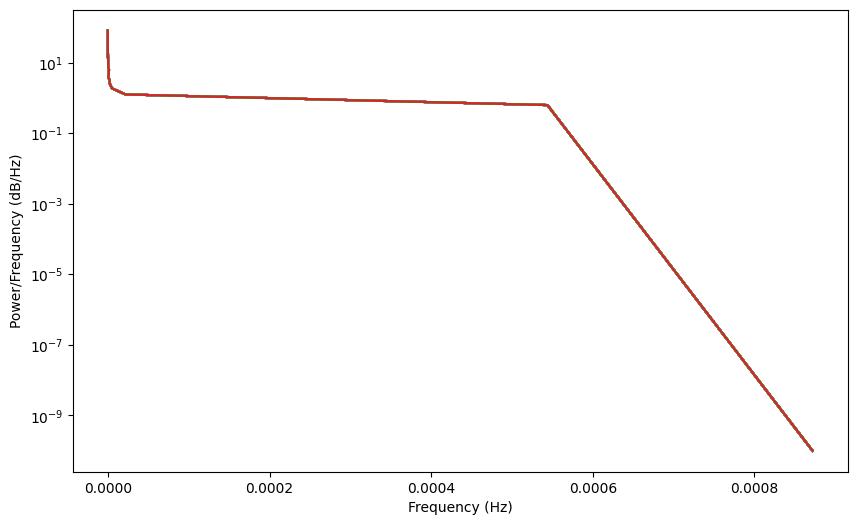

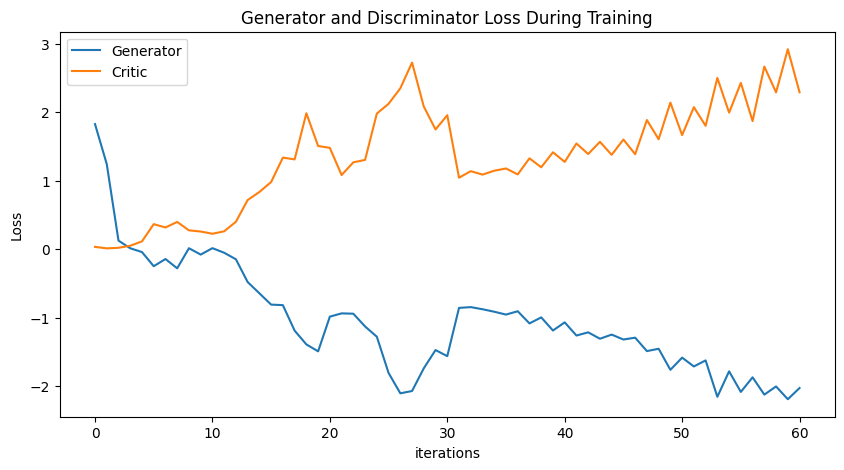

Epoch 70: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099, -0.053555110911149145, -0.1490088985829475, -0.481653089647959, -0.6459408744589094, -0.8110857214240685, -0.8191183042887766, -1.191360196023375, -1.3923246099509072, -1.4939039839104153, -0.9867567959728697, -0.939174374033741, -0.9439010985909159, -1.130508398141421, -1.2797913014053697, -1.8091860329912755, -2.106912181630736, -2.073371218945991, -1.741611448713781, -1.4749941620700076, -1.5638996464619386, -0.8591007689606854, -0.8477450651678754, -0.8787081461593661, -0.9150682154765513, -0.9567433858882582, -0.9079217926209503, -1.0857234871312753, -0.9976619999427864, -1.1894297568119283, -1.0704649147753322, -1.2627880827572628, -1.2160270206575645, -1.3097102167428694, -1.249192655442032, -1.321075664299302, -1.2940571259

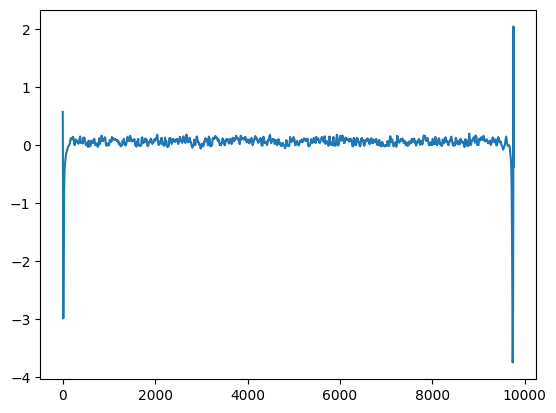

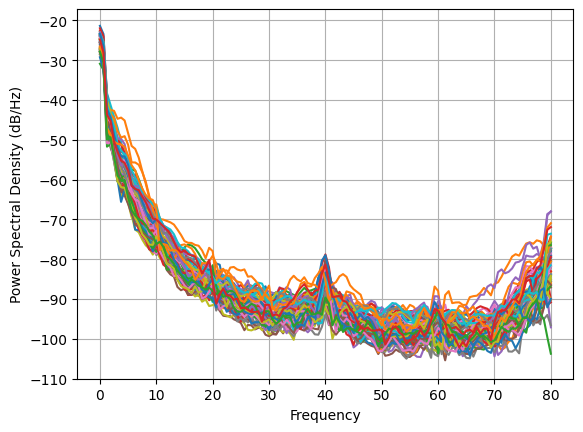

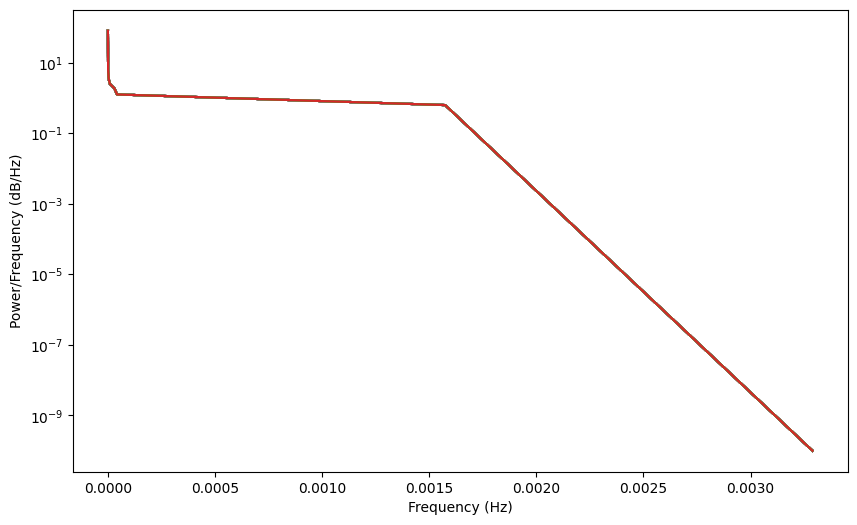

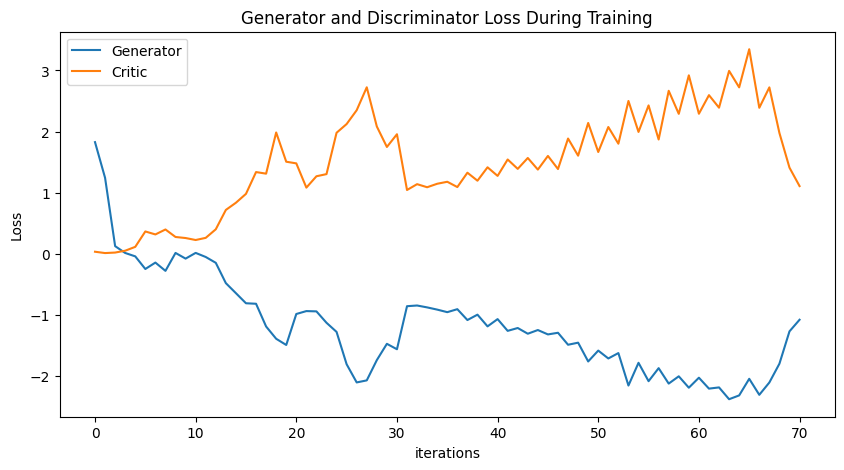

Epoch 80: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099, -0.053555110911149145, -0.1490088985829475, -0.481653089647959, -0.6459408744589094, -0.8110857214240685, -0.8191183042887766, -1.191360196023375, -1.3923246099509072, -1.4939039839104153, -0.9867567959728697, -0.939174374033741, -0.9439010985909159, -1.130508398141421, -1.2797913014053697, -1.8091860329912755, -2.106912181630736, -2.073371218945991, -1.741611448713781, -1.4749941620700076, -1.5638996464619386, -0.8591007689606854, -0.8477450651678754, -0.8787081461593661, -0.9150682154765513, -0.9567433858882582, -0.9079217926209503, -1.0857234871312753, -0.9976619999427864, -1.1894297568119283, -1.0704649147753322, -1.2627880827572628, -1.2160270206575645, -1.3097102167428694, -1.249192655442032, -1.321075664299302, -1.2940571259

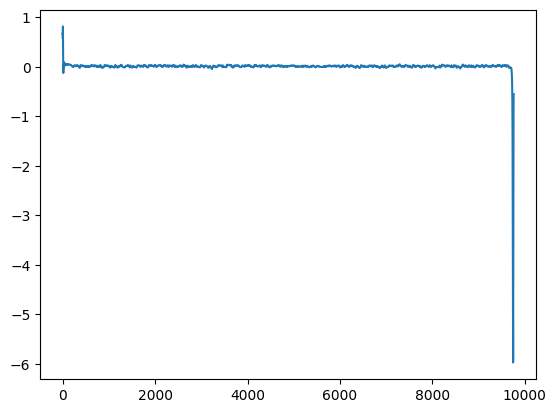

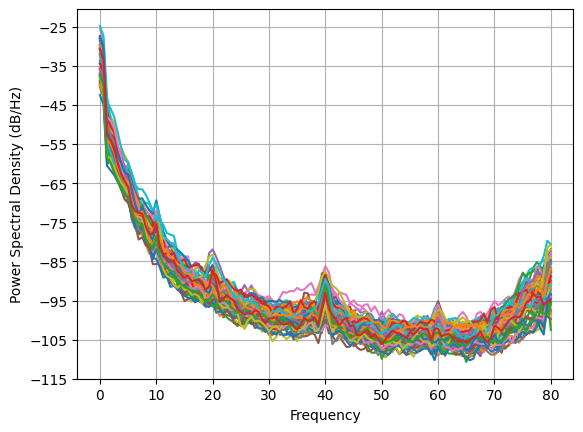

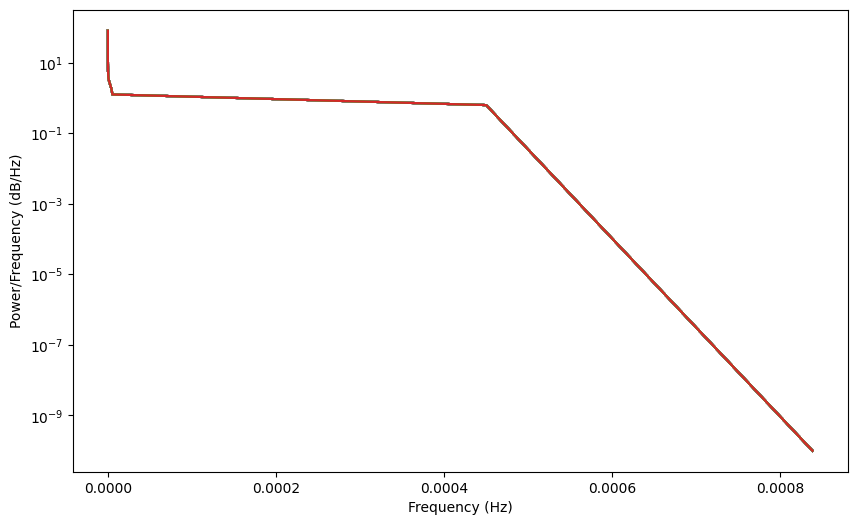

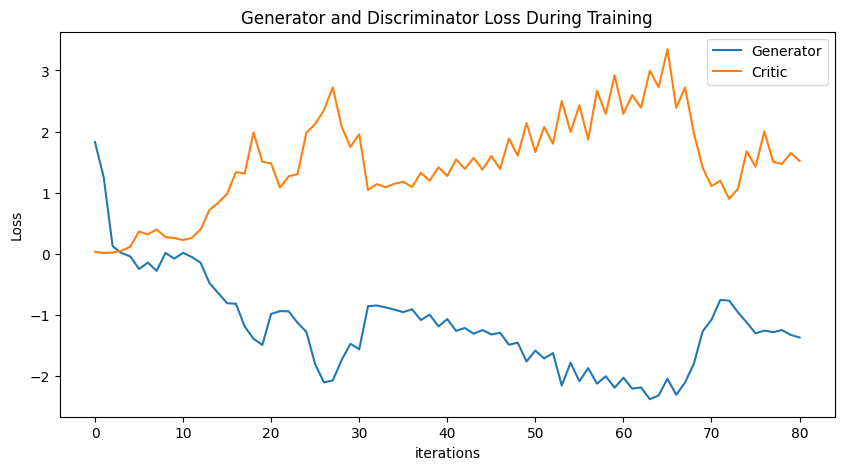

Epoch 90: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099, -0.053555110911149145, -0.1490088985829475, -0.481653089647959, -0.6459408744589094, -0.8110857214240685, -0.8191183042887766, -1.191360196023375, -1.3923246099509072, -1.4939039839104153, -0.9867567959728697, -0.939174374033741, -0.9439010985909159, -1.130508398141421, -1.2797913014053697, -1.8091860329912755, -2.106912181630736, -2.073371218945991, -1.741611448713781, -1.4749941620700076, -1.5638996464619386, -0.8591007689606854, -0.8477450651678754, -0.8787081461593661, -0.9150682154765513, -0.9567433858882582, -0.9079217926209503, -1.0857234871312753, -0.9976619999427864, -1.1894297568119283, -1.0704649147753322, -1.2627880827572628, -1.2160270206575645, -1.3097102167428694, -1.249192655442032, -1.321075664299302, -1.2940571259

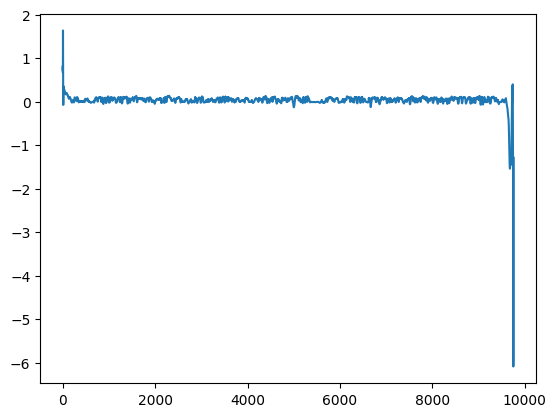

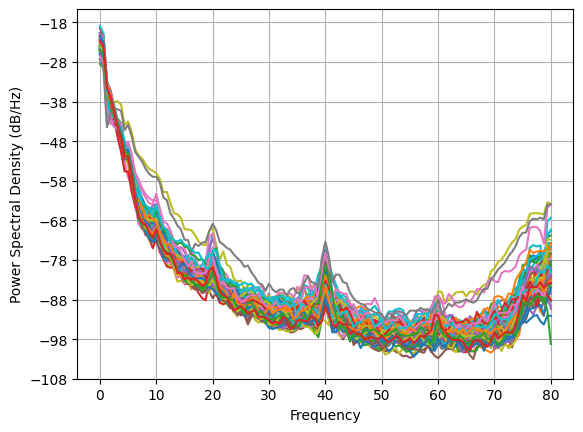

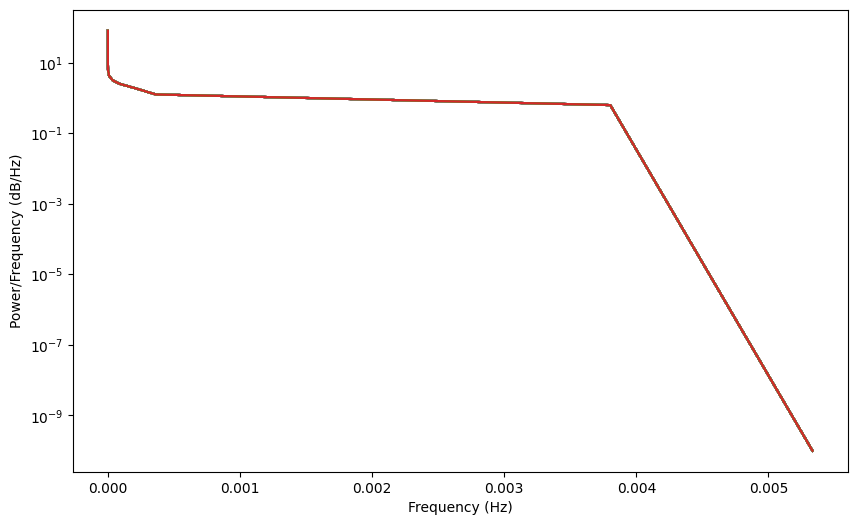

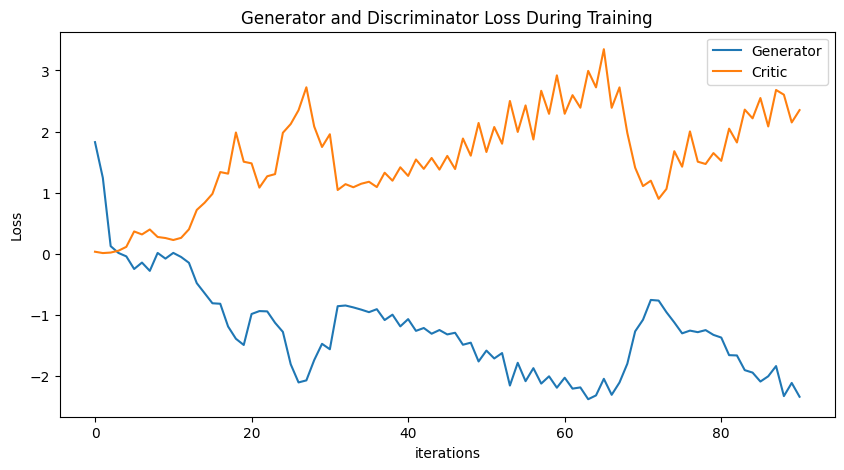

Epoch 100: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099, -0.053555110911149145, -0.1490088985829475, -0.481653089647959, -0.6459408744589094, -0.8110857214240685, -0.8191183042887766, -1.191360196023375, -1.3923246099509072, -1.4939039839104153, -0.9867567959728697, -0.939174374033741, -0.9439010985909159, -1.130508398141421, -1.2797913014053697, -1.8091860329912755, -2.106912181630736, -2.073371218945991, -1.741611448713781, -1.4749941620700076, -1.5638996464619386, -0.8591007689606854, -0.8477450651678754, -0.8787081461593661, -0.9150682154765513, -0.9567433858882582, -0.9079217926209503, -1.0857234871312753, -0.9976619999427864, -1.1894297568119283, -1.0704649147753322, -1.2627880827572628, -1.2160270206575645, -1.3097102167428694, -1.249192655442032, -1.321075664299302, -1.294057125

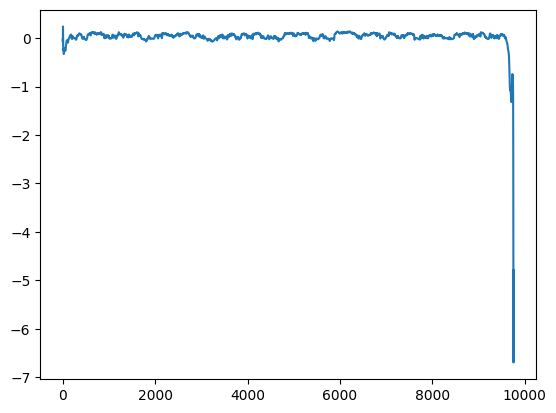

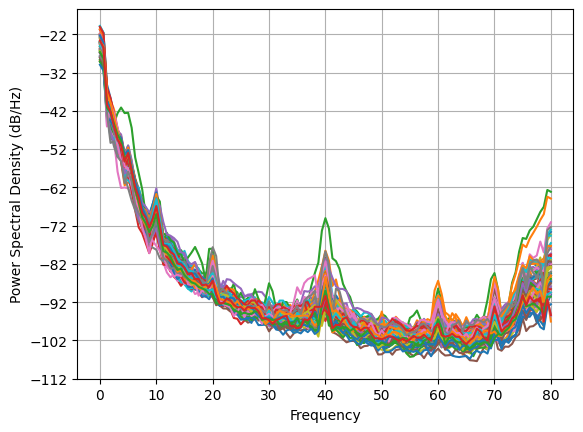

Epoch 110: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099, -0.053555110911149145, -0.1490088985829475, -0.481653089647959, -0.6459408744589094, -0.8110857214240685, -0.8191183042887766, -1.191360196023375, -1.3923246099509072, -1.4939039839104153, -0.9867567959728697, -0.939174374033741, -0.9439010985909159, -1.130508398141421, -1.2797913014053697, -1.8091860329912755, -2.106912181630736, -2.073371218945991, -1.741611448713781, -1.4749941620700076, -1.5638996464619386, -0.8591007689606854, -0.8477450651678754, -0.8787081461593661, -0.9150682154765513, -0.9567433858882582, -0.9079217926209503, -1.0857234871312753, -0.9976619999427864, -1.1894297568119283, -1.0704649147753322, -1.2627880827572628, -1.2160270206575645, -1.3097102167428694, -1.249192655442032, -1.321075664299302, -1.294057125

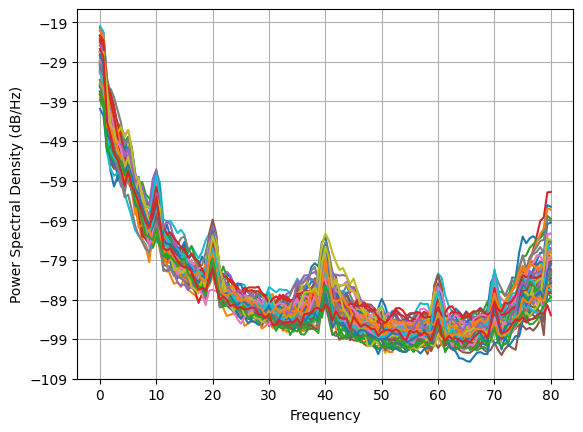

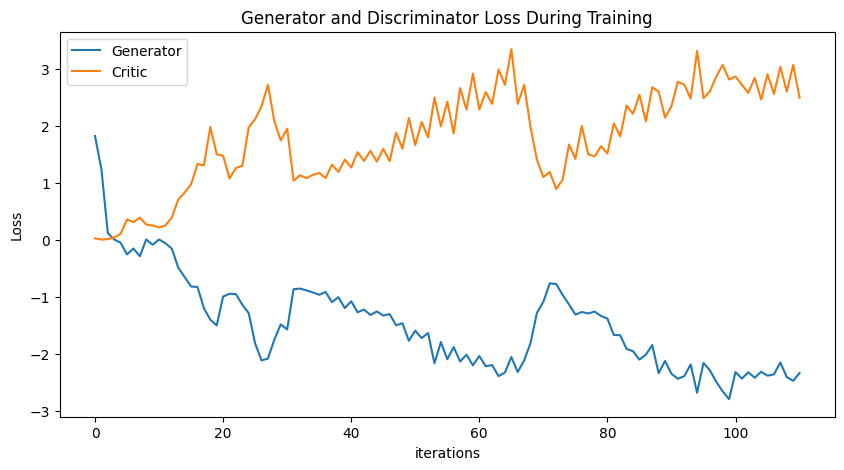

Epoch 120: Critic error ([1.8264334089185883, 1.2423659678178414, 0.12389627473788711, 0.012056891487889253, -0.04358463147655253, -0.2500785090806069, -0.14515403450987696, -0.2808616029379748, 0.012696776924949638, -0.08024498345545034, 0.01345730847284099, -0.053555110911149145, -0.1490088985829475, -0.481653089647959, -0.6459408744589094, -0.8110857214240685, -0.8191183042887766, -1.191360196023375, -1.3923246099509072, -1.4939039839104153, -0.9867567959728697, -0.939174374033741, -0.9439010985909159, -1.130508398141421, -1.2797913014053697, -1.8091860329912755, -2.106912181630736, -2.073371218945991, -1.741611448713781, -1.4749941620700076, -1.5638996464619386, -0.8591007689606854, -0.8477450651678754, -0.8787081461593661, -0.9150682154765513, -0.9567433858882582, -0.9079217926209503, -1.0857234871312753, -0.9976619999427864, -1.1894297568119283, -1.0704649147753322, -1.2627880827572628, -1.2160270206575645, -1.3097102167428694, -1.249192655442032, -1.321075664299302, -1.294057125

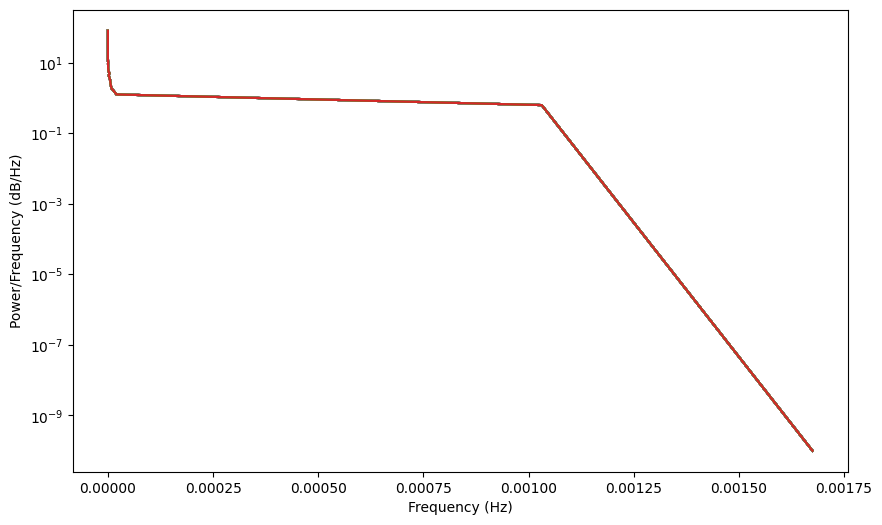

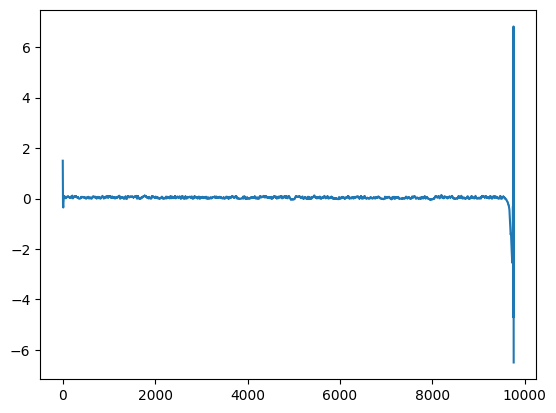

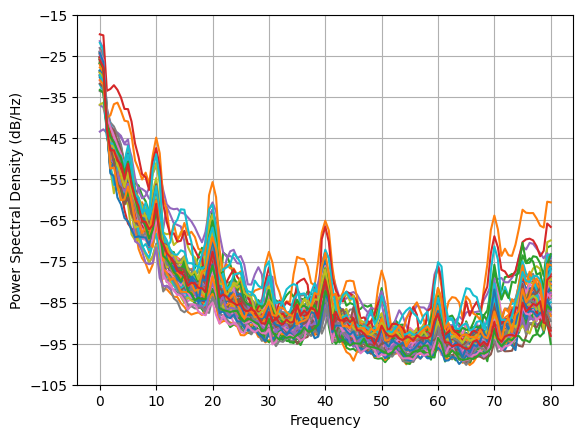

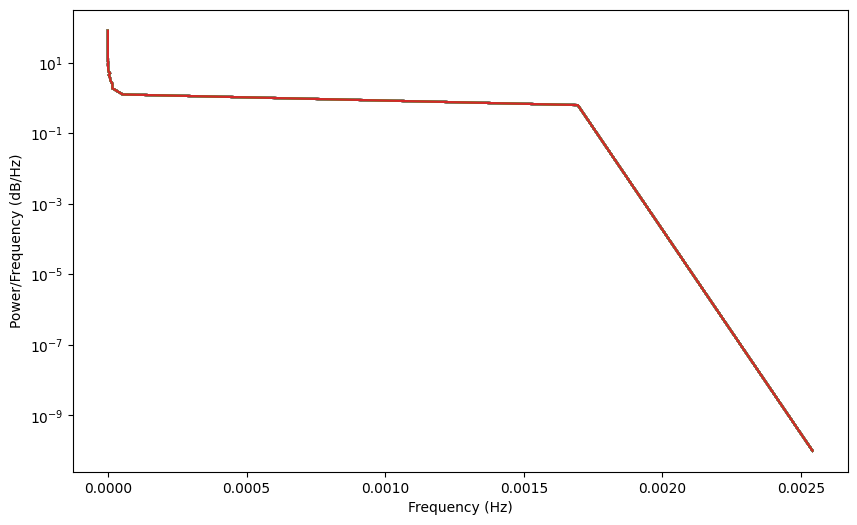

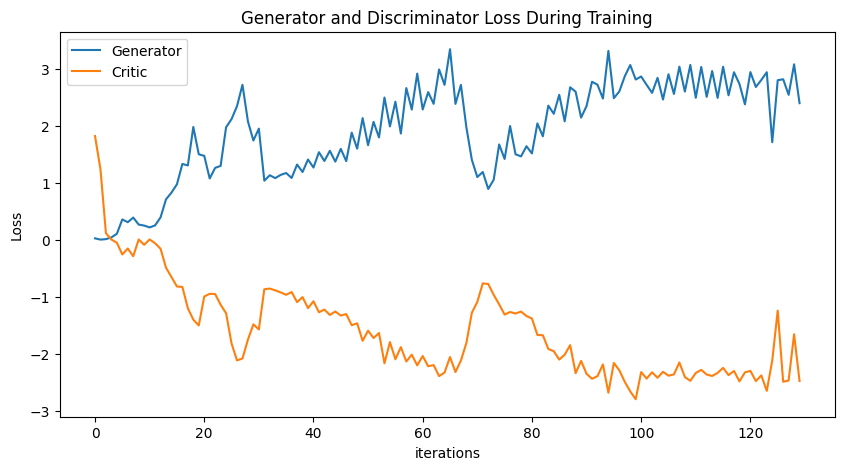

In [17]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 10
training_data = torch.tensor(np.load('training_closed.npy'))
BATCH_SIZE = np.shape(training_data)[0]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            critic_real = D(real).reshape(-1)
            loss_critic_real = -torch.mean(critic_real)
            noise = sample_normal_distribution(BATCH_SIZE, 640, 305)
            fake = G(noise)
            critic_fake = D(fake).reshape(-1)
            loss_critic_fake = torch.mean(critic_fake)
            gp = gradient_penalty(D, real, fake) * LAMBDA_GP
            D.zero_grad()
            loss_critic = loss_critic_real + loss_critic_fake + gp
            loss_critic.backward()
            critic_optimizer.step()  

        noise = sample_normal_distribution(BATCH_SIZE, 640, 305)
        fake = G(noise)
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
        
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(fake, critic_err, gen_err)

    return critic_err, gen_err, fake, D, G

critic_err, gen_err, generated_data_closed, disc, gen = train()

torch.save(gen, 'generator_eyes_closed.pt')
torch.save(disc, 'discriminator_eyes_closed.pt')
np.save('640channels-closed.npy', generated_data_closed.detach())
plot_everything(generated_data_closed, gen_err, critic_err)
generated_data_closed = None

Epoch 0: Critic error ([1.021696020304355]) Generator err ([0.008901560679078102])


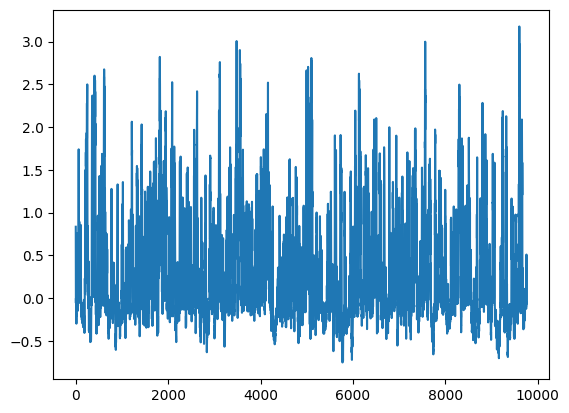

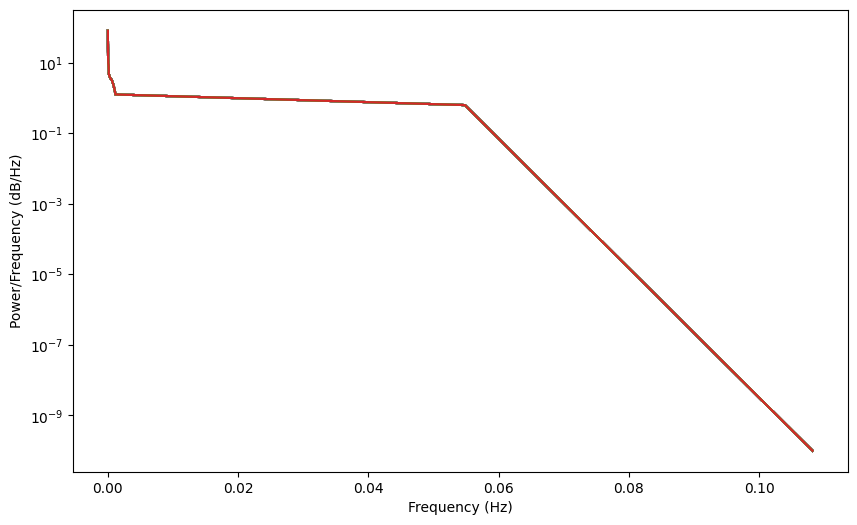

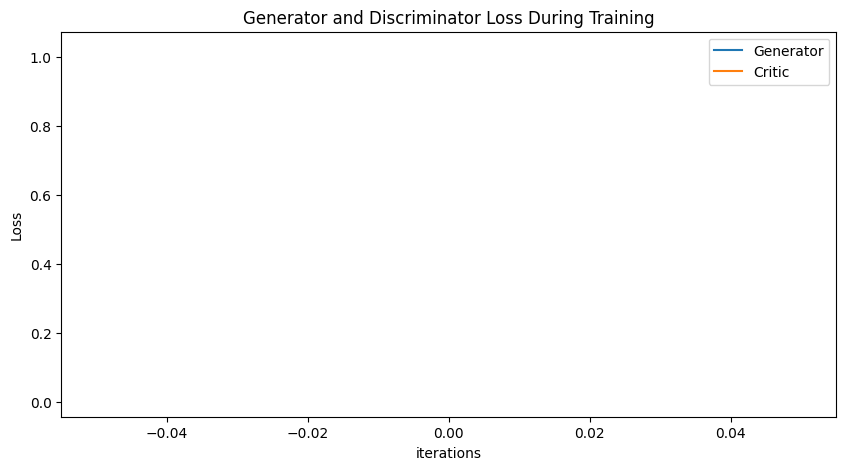

Epoch 10: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348]) Generator err ([0.008901560679078102, -0.05360204726457596, -0.20881448686122894, -0.21448107063770294, -0.09685173630714417, -0.15295538306236267, -0.23460395634174347, -0.21271578967571259, -0.21906721591949463, -0.17293700575828552, -0.199885293841362])


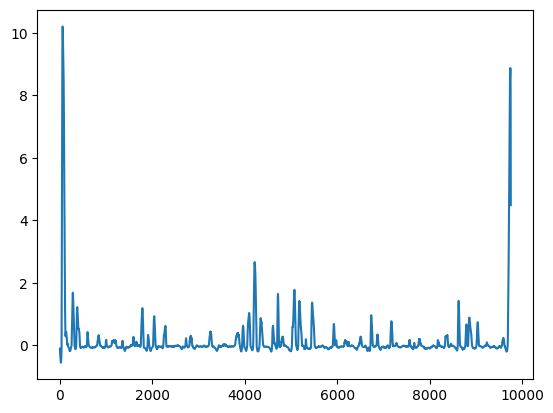

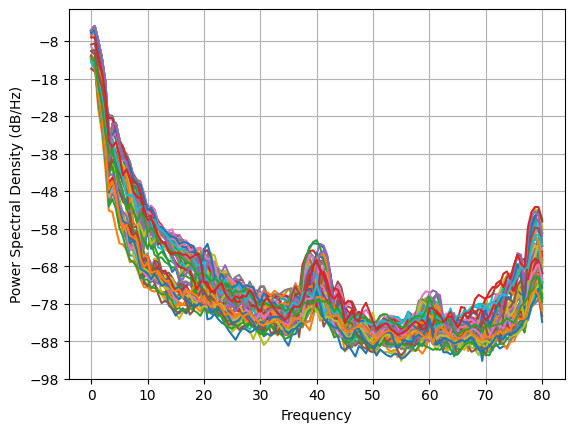

Epoch 20: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348, 0.2729851596078793, 0.2900732391498444, 0.21192772622978023, 0.18585596222397838, 0.10299627371870293, 0.11265718278210908, 0.08287444210203201, 0.024252402105886806, 0.011330095416299715, -0.00525239867733697]) Generator err ([0.008901560679078102, -0.05360204726457596, -0.20881448686122894, -0.21448107063770294, -0.09685173630714417, -0.15295538306236267, -0.23460395634174347, -0.21271578967571259, -0.21906721591949463, -0.17293700575828552, -0.199885293841362, -0.18969841301441193, -0.21539971232414246, -0.15508976578712463, -0.10850358009338379, -0.05212803930044174, -0.05678141117095947, -0.033396389335393906, 0.0069901770912110806, 0.02209922857582569, 0.04427153244614601])


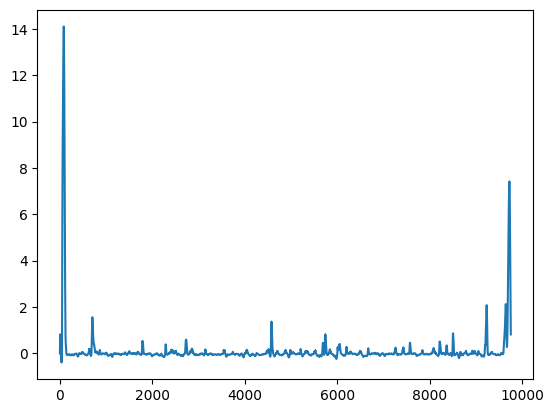

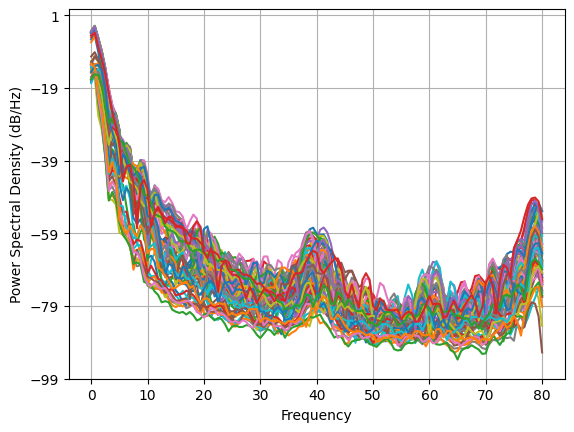

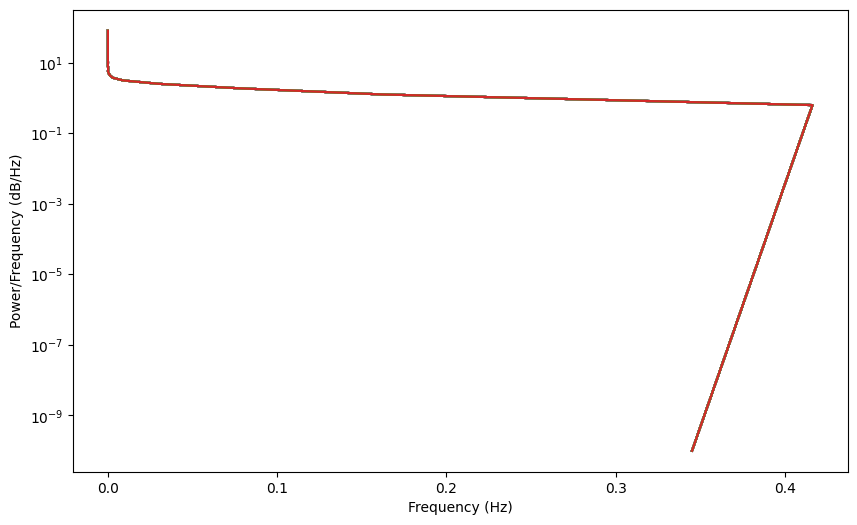

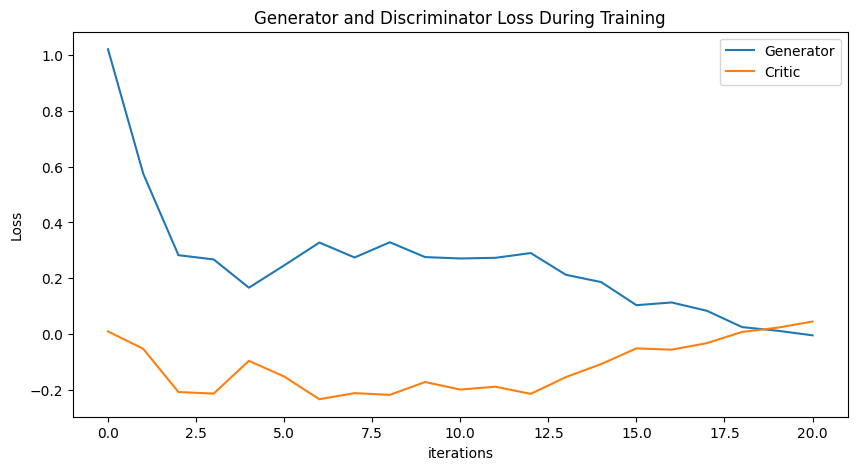

Epoch 30: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348, 0.2729851596078793, 0.2900732391498444, 0.21192772622978023, 0.18585596222397838, 0.10299627371870293, 0.11265718278210908, 0.08287444210203201, 0.024252402105886806, 0.011330095416299715, -0.00525239867733697, -0.02905297038661378, -0.04174596744786184, -0.0617084636633795, -0.0736481869754706, -0.06987606024481585, -0.07489530999912447, -0.08887276613938691, -0.07662745968524705, -0.11120218262816847, -0.13357053300025334]) Generator err ([0.008901560679078102, -0.05360204726457596, -0.20881448686122894, -0.21448107063770294, -0.09685173630714417, -0.15295538306236267, -0.23460395634174347, -0.21271578967571259, -0.21906721591949463, -0.17293700575828552, -0.199885293841362, -0.18969841301441193, -0.21539971232414246, -0.15508976578712463, -

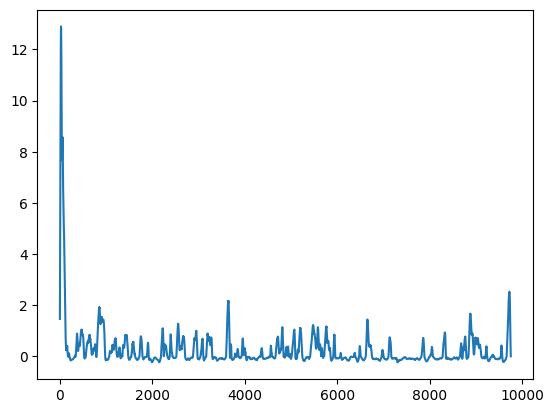

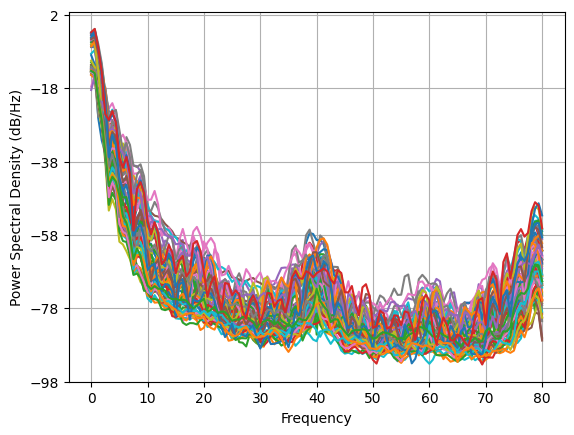

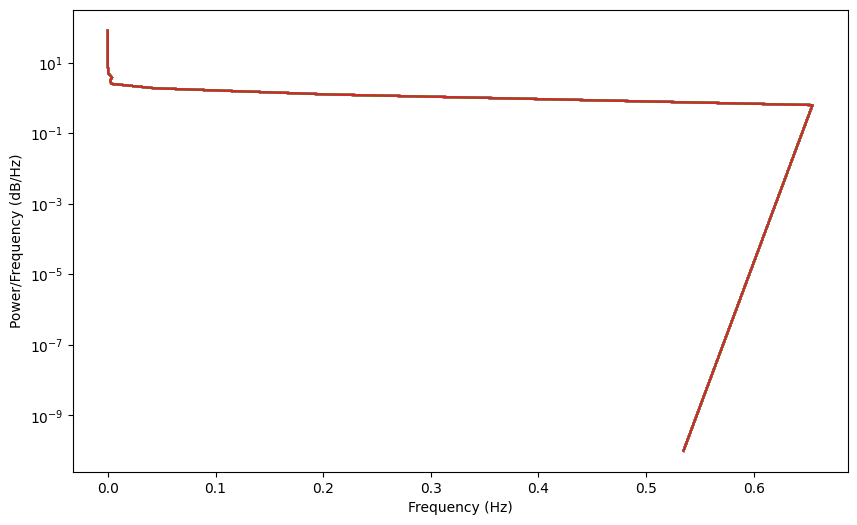

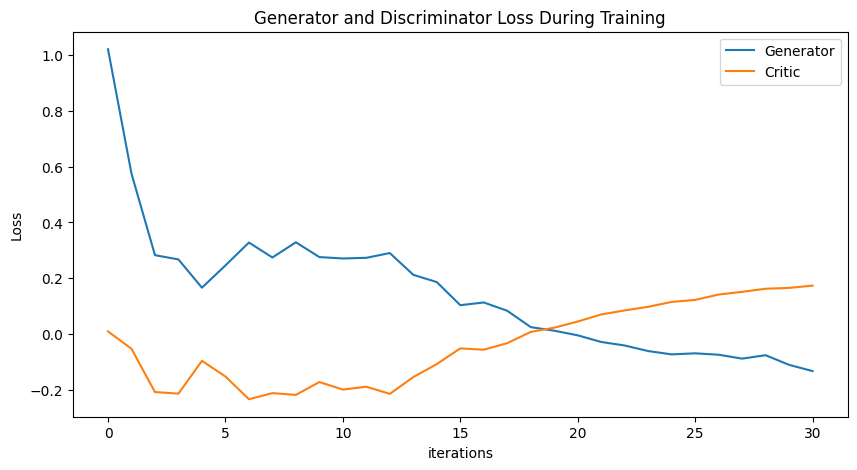

Epoch 40: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348, 0.2729851596078793, 0.2900732391498444, 0.21192772622978023, 0.18585596222397838, 0.10299627371870293, 0.11265718278210908, 0.08287444210203201, 0.024252402105886806, 0.011330095416299715, -0.00525239867733697, -0.02905297038661378, -0.04174596744786184, -0.0617084636633795, -0.0736481869754706, -0.06987606024481585, -0.07489530999912447, -0.08887276613938691, -0.07662745968524705, -0.11120218262816847, -0.13357053300025334, -0.13752825256067444, -0.14061189603258686, -0.16444867069255342, -0.19728295204536384, -0.252883012515175, -0.2901617006441156, -0.33452732852185896, -0.3551721873182914, -0.36083041613811595, -0.42391723413793403]) Generator err ([0.008901560679078102, -0.05360204726457596, -0.20881448686122894, -0.21448107063770294, -0.

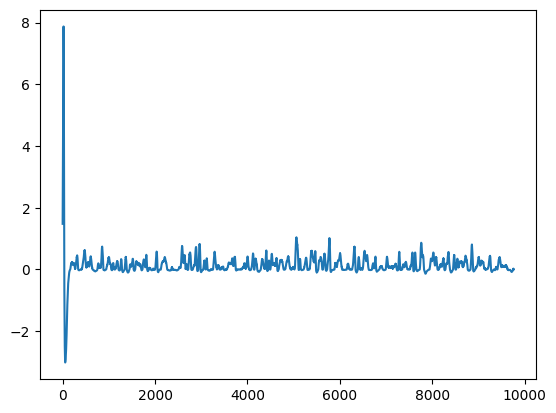

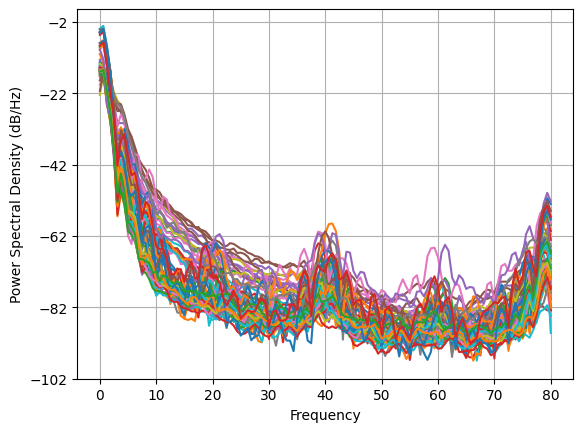

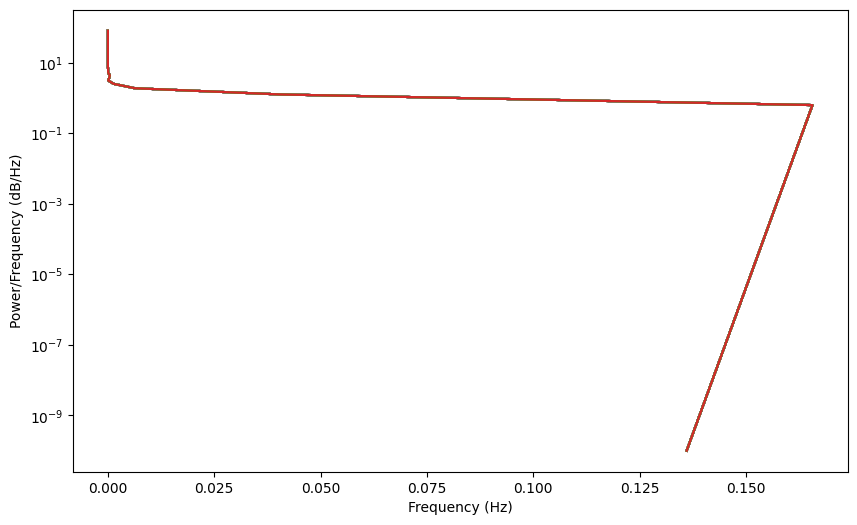

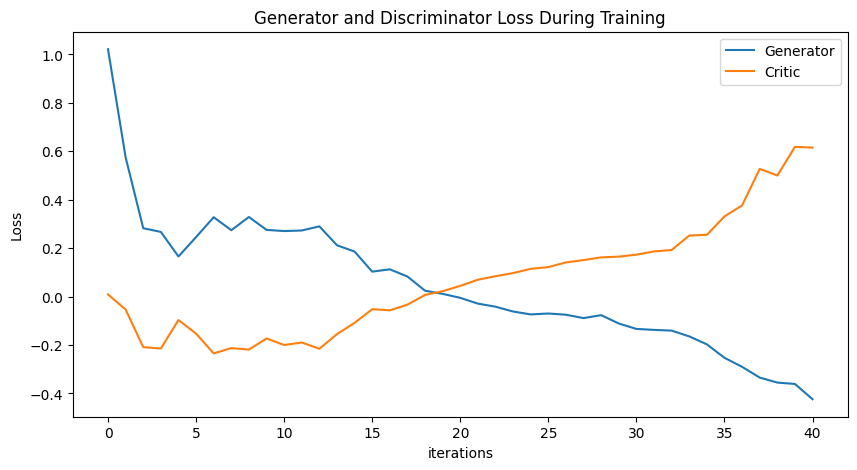

Epoch 50: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348, 0.2729851596078793, 0.2900732391498444, 0.21192772622978023, 0.18585596222397838, 0.10299627371870293, 0.11265718278210908, 0.08287444210203201, 0.024252402105886806, 0.011330095416299715, -0.00525239867733697, -0.02905297038661378, -0.04174596744786184, -0.0617084636633795, -0.0736481869754706, -0.06987606024481585, -0.07489530999912447, -0.08887276613938691, -0.07662745968524705, -0.11120218262816847, -0.13357053300025334, -0.13752825256067444, -0.14061189603258686, -0.16444867069255342, -0.19728295204536384, -0.252883012515175, -0.2901617006441156, -0.33452732852185896, -0.3551721873182914, -0.36083041613811595, -0.42391723413793403, -0.4606565382901305, -0.5132359495855876, -0.5791282342751517, -0.6422781975985904, -0.5574482949995955, -0.

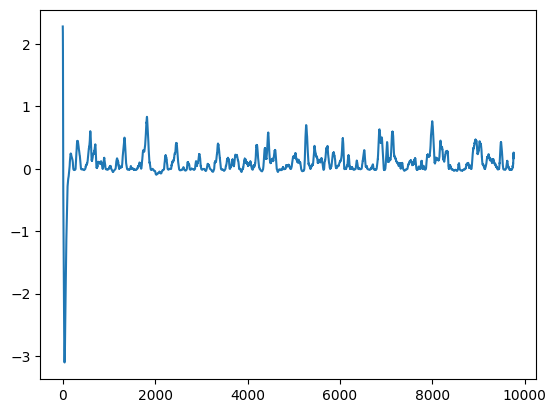

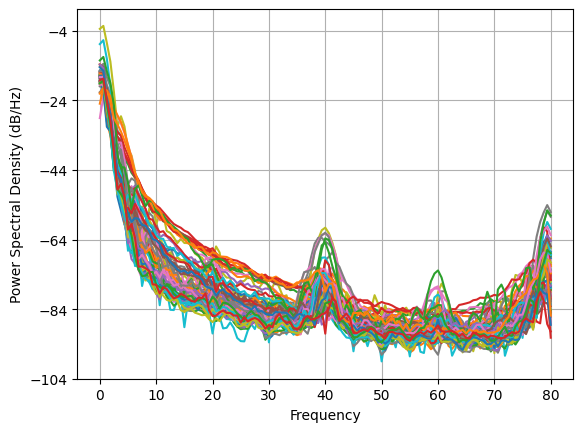

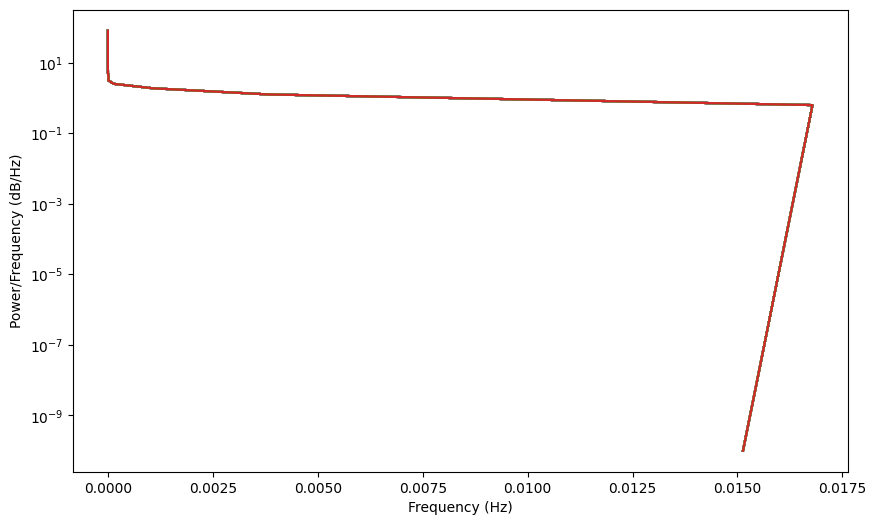

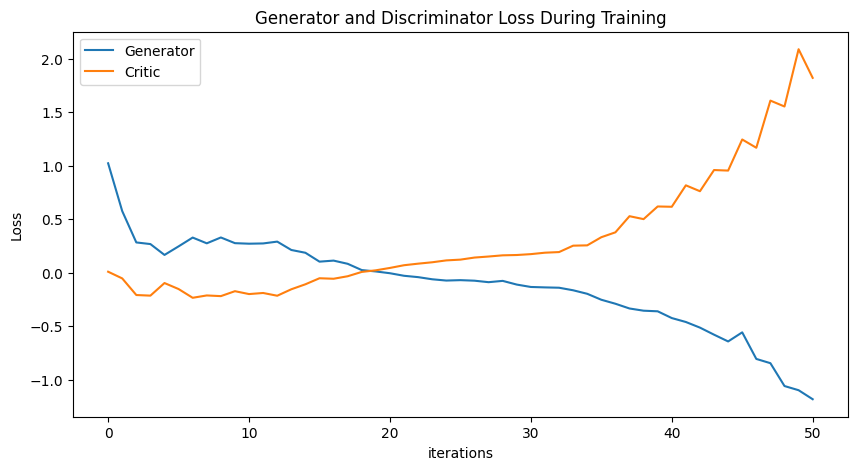

Epoch 60: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348, 0.2729851596078793, 0.2900732391498444, 0.21192772622978023, 0.18585596222397838, 0.10299627371870293, 0.11265718278210908, 0.08287444210203201, 0.024252402105886806, 0.011330095416299715, -0.00525239867733697, -0.02905297038661378, -0.04174596744786184, -0.0617084636633795, -0.0736481869754706, -0.06987606024481585, -0.07489530999912447, -0.08887276613938691, -0.07662745968524705, -0.11120218262816847, -0.13357053300025334, -0.13752825256067444, -0.14061189603258686, -0.16444867069255342, -0.19728295204536384, -0.252883012515175, -0.2901617006441156, -0.33452732852185896, -0.3551721873182914, -0.36083041613811595, -0.42391723413793403, -0.4606565382901305, -0.5132359495855876, -0.5791282342751517, -0.6422781975985904, -0.5574482949995955, -0.

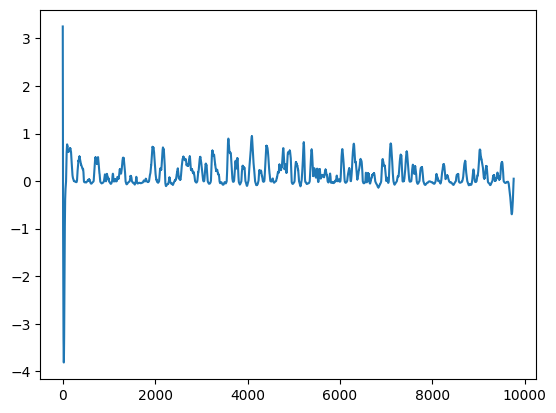

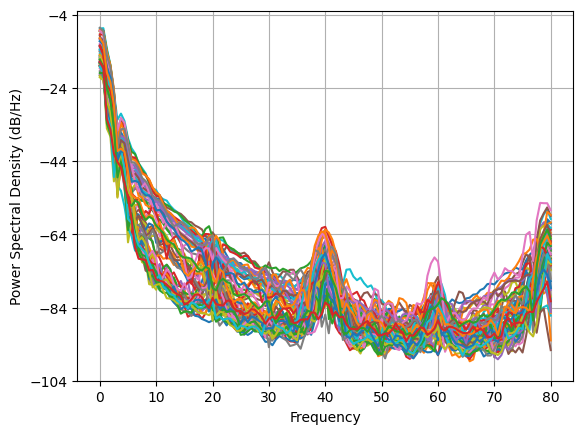

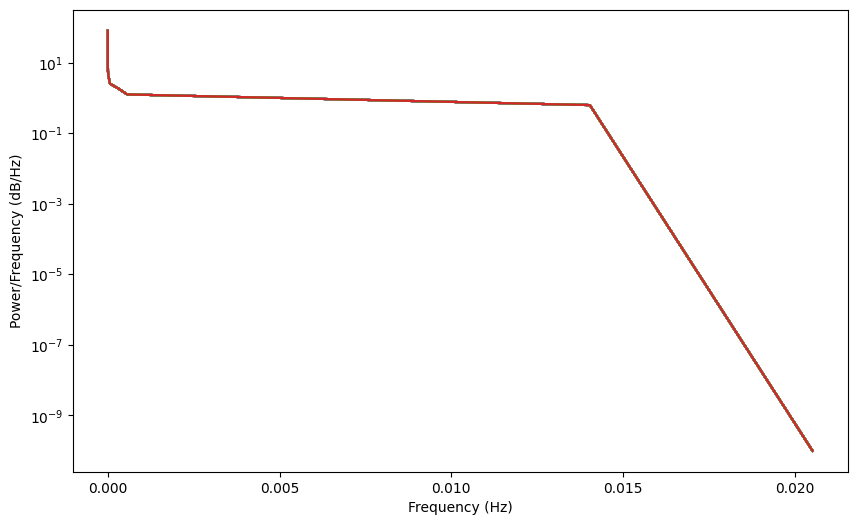

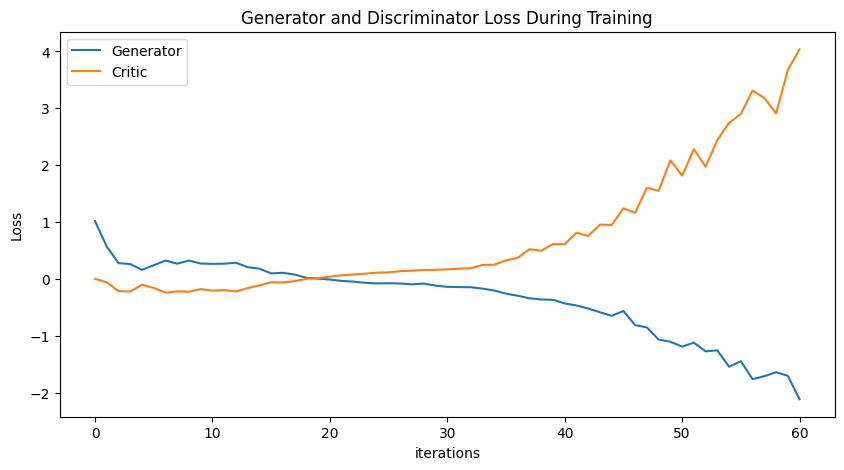

Epoch 70: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348, 0.2729851596078793, 0.2900732391498444, 0.21192772622978023, 0.18585596222397838, 0.10299627371870293, 0.11265718278210908, 0.08287444210203201, 0.024252402105886806, 0.011330095416299715, -0.00525239867733697, -0.02905297038661378, -0.04174596744786184, -0.0617084636633795, -0.0736481869754706, -0.06987606024481585, -0.07489530999912447, -0.08887276613938691, -0.07662745968524705, -0.11120218262816847, -0.13357053300025334, -0.13752825256067444, -0.14061189603258686, -0.16444867069255342, -0.19728295204536384, -0.252883012515175, -0.2901617006441156, -0.33452732852185896, -0.3551721873182914, -0.36083041613811595, -0.42391723413793403, -0.4606565382901305, -0.5132359495855876, -0.5791282342751517, -0.6422781975985904, -0.5574482949995955, -0.

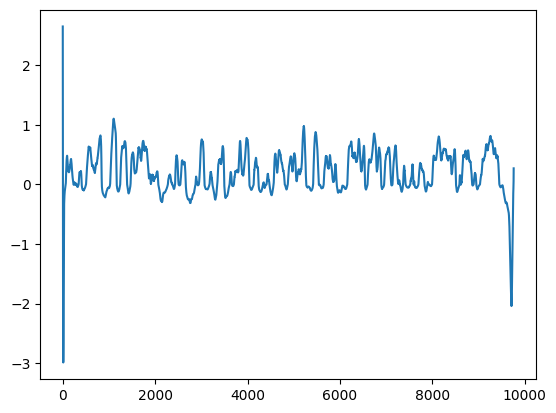

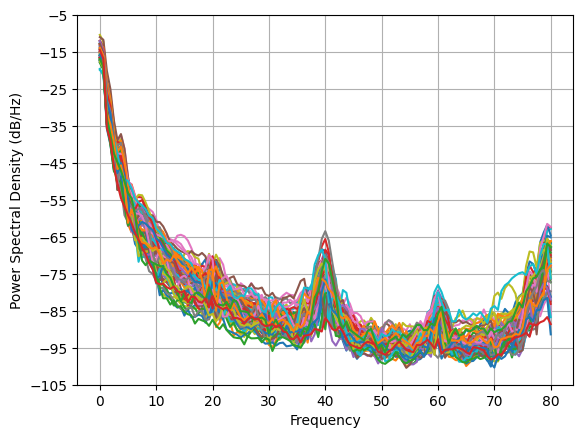

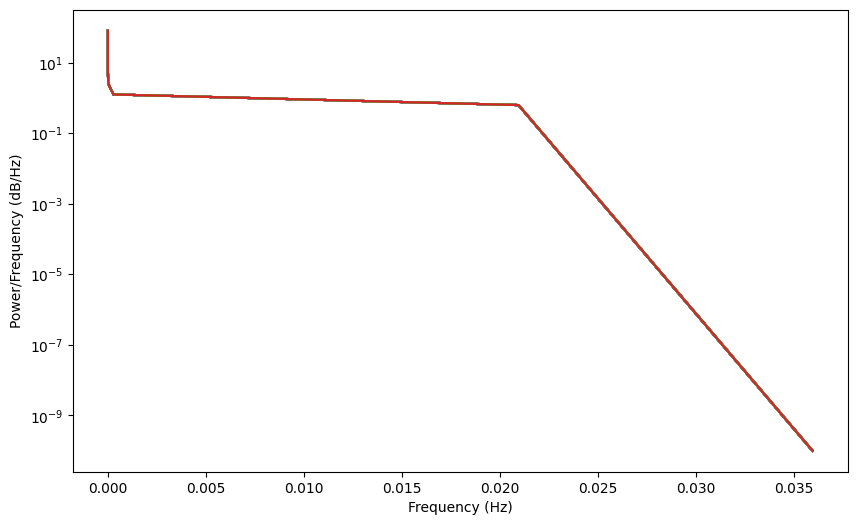

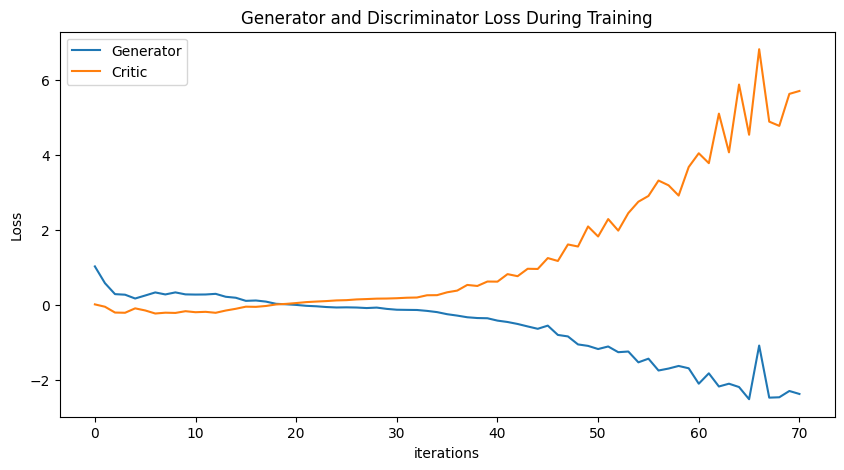

Epoch 80: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348, 0.2729851596078793, 0.2900732391498444, 0.21192772622978023, 0.18585596222397838, 0.10299627371870293, 0.11265718278210908, 0.08287444210203201, 0.024252402105886806, 0.011330095416299715, -0.00525239867733697, -0.02905297038661378, -0.04174596744786184, -0.0617084636633795, -0.0736481869754706, -0.06987606024481585, -0.07489530999912447, -0.08887276613938691, -0.07662745968524705, -0.11120218262816847, -0.13357053300025334, -0.13752825256067444, -0.14061189603258686, -0.16444867069255342, -0.19728295204536384, -0.252883012515175, -0.2901617006441156, -0.33452732852185896, -0.3551721873182914, -0.36083041613811595, -0.42391723413793403, -0.4606565382901305, -0.5132359495855876, -0.5791282342751517, -0.6422781975985904, -0.5574482949995955, -0.

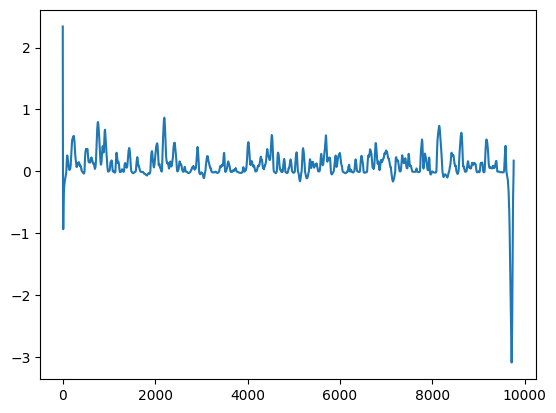

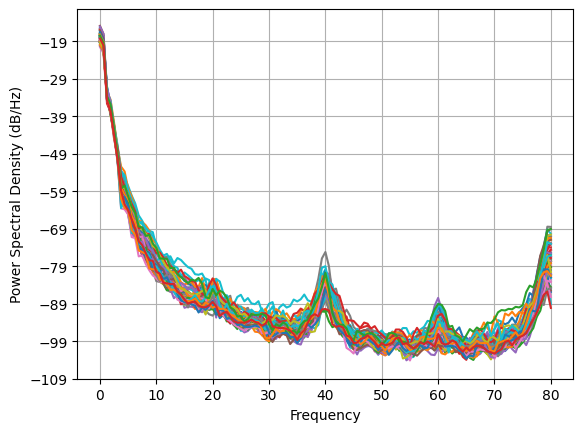

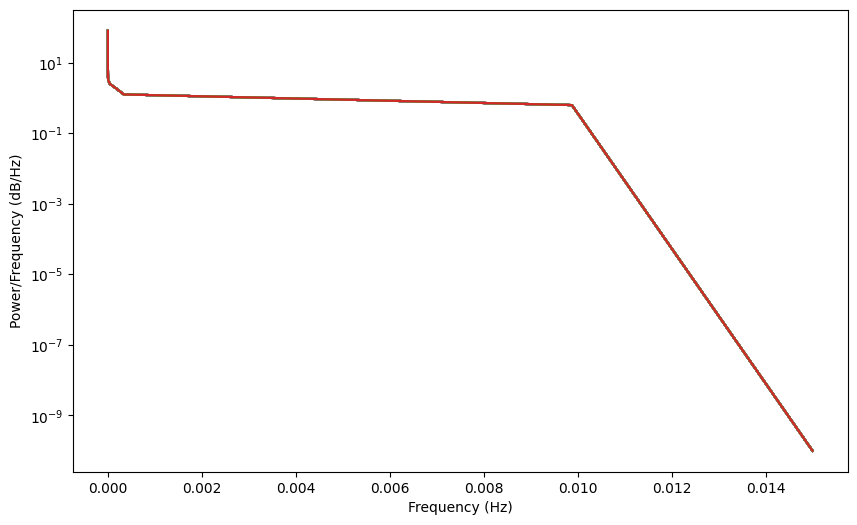

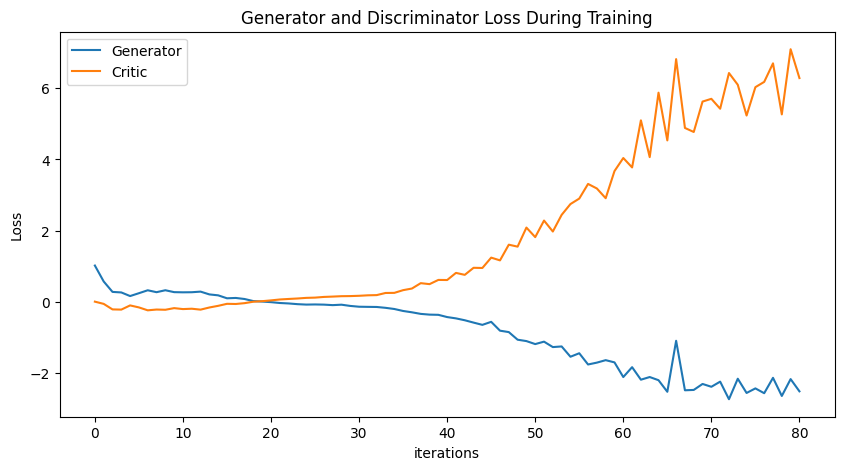

Epoch 90: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348, 0.2729851596078793, 0.2900732391498444, 0.21192772622978023, 0.18585596222397838, 0.10299627371870293, 0.11265718278210908, 0.08287444210203201, 0.024252402105886806, 0.011330095416299715, -0.00525239867733697, -0.02905297038661378, -0.04174596744786184, -0.0617084636633795, -0.0736481869754706, -0.06987606024481585, -0.07489530999912447, -0.08887276613938691, -0.07662745968524705, -0.11120218262816847, -0.13357053300025334, -0.13752825256067444, -0.14061189603258686, -0.16444867069255342, -0.19728295204536384, -0.252883012515175, -0.2901617006441156, -0.33452732852185896, -0.3551721873182914, -0.36083041613811595, -0.42391723413793403, -0.4606565382901305, -0.5132359495855876, -0.5791282342751517, -0.6422781975985904, -0.5574482949995955, -0.

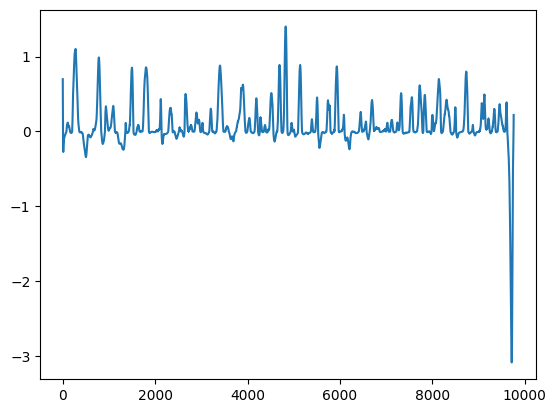

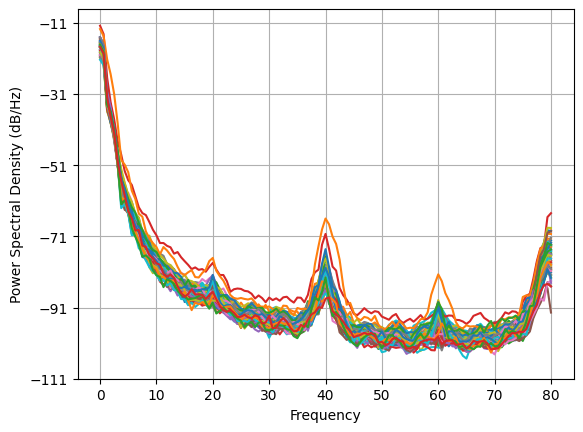

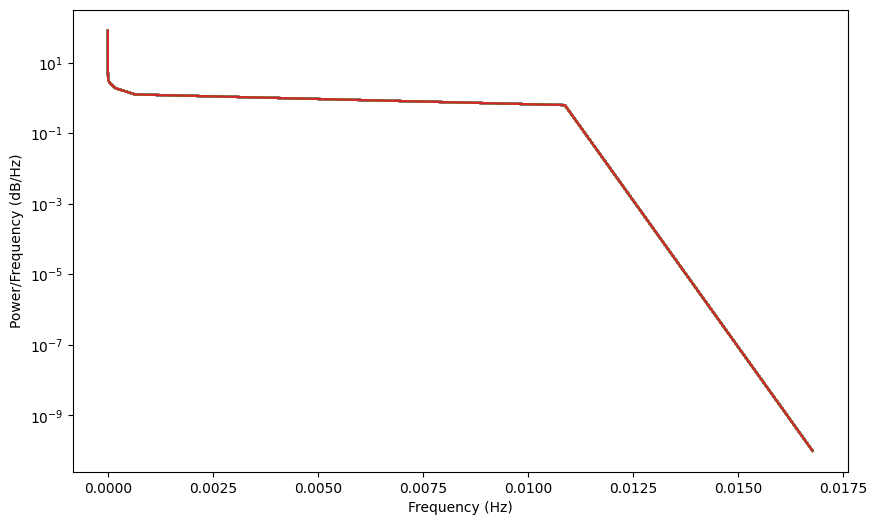

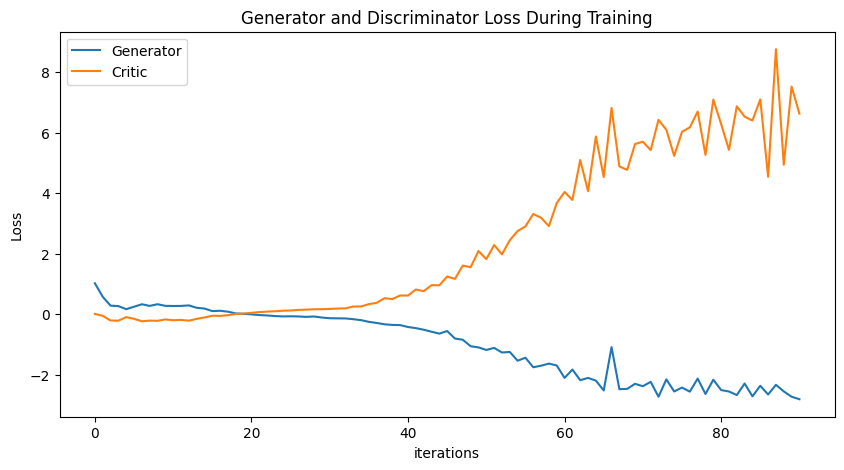

Epoch 100: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348, 0.2729851596078793, 0.2900732391498444, 0.21192772622978023, 0.18585596222397838, 0.10299627371870293, 0.11265718278210908, 0.08287444210203201, 0.024252402105886806, 0.011330095416299715, -0.00525239867733697, -0.02905297038661378, -0.04174596744786184, -0.0617084636633795, -0.0736481869754706, -0.06987606024481585, -0.07489530999912447, -0.08887276613938691, -0.07662745968524705, -0.11120218262816847, -0.13357053300025334, -0.13752825256067444, -0.14061189603258686, -0.16444867069255342, -0.19728295204536384, -0.252883012515175, -0.2901617006441156, -0.33452732852185896, -0.3551721873182914, -0.36083041613811595, -0.42391723413793403, -0.4606565382901305, -0.5132359495855876, -0.5791282342751517, -0.6422781975985904, -0.5574482949995955, -0

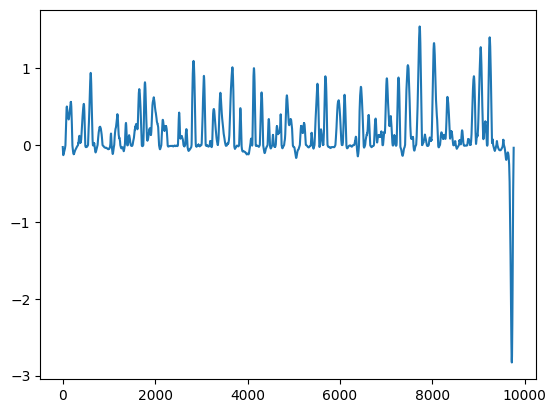

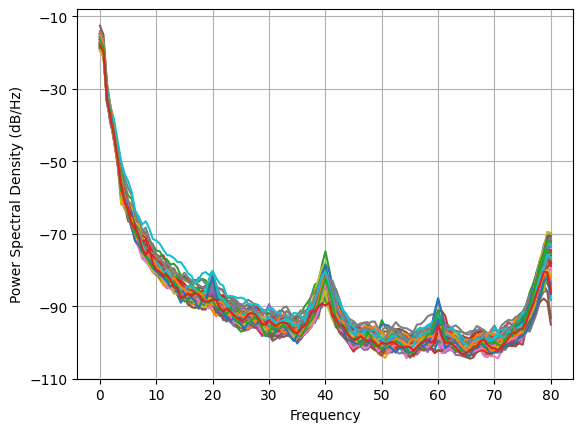

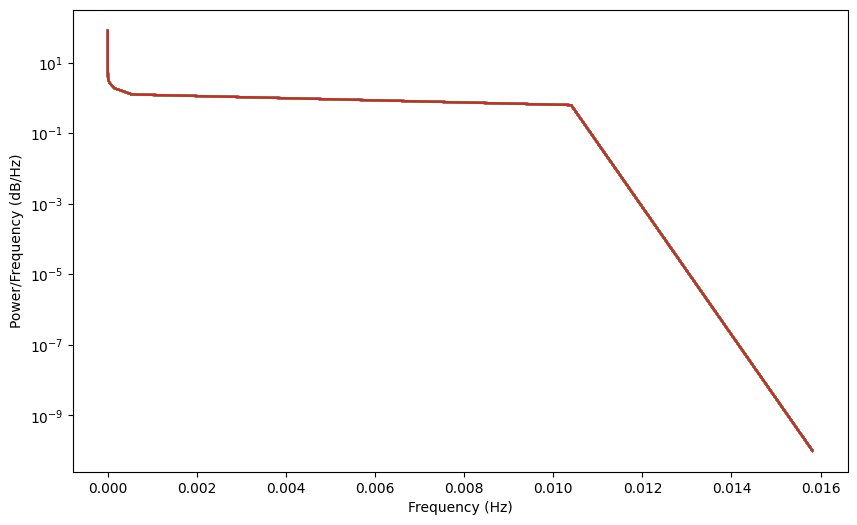

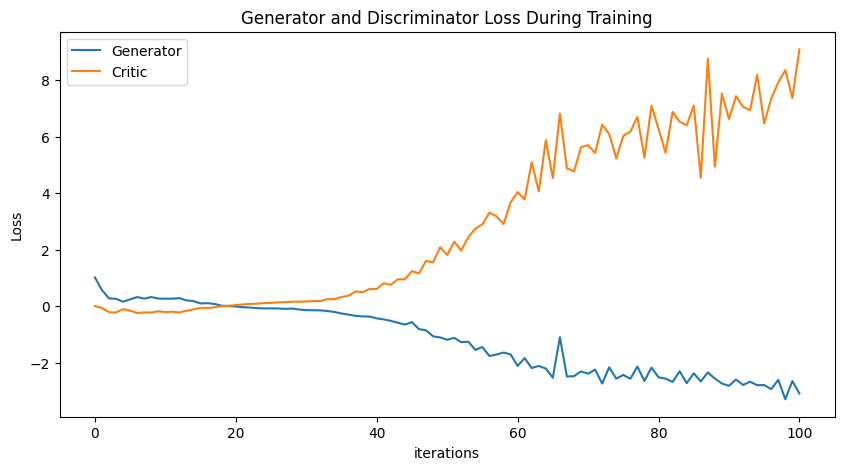

Epoch 110: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348, 0.2729851596078793, 0.2900732391498444, 0.21192772622978023, 0.18585596222397838, 0.10299627371870293, 0.11265718278210908, 0.08287444210203201, 0.024252402105886806, 0.011330095416299715, -0.00525239867733697, -0.02905297038661378, -0.04174596744786184, -0.0617084636633795, -0.0736481869754706, -0.06987606024481585, -0.07489530999912447, -0.08887276613938691, -0.07662745968524705, -0.11120218262816847, -0.13357053300025334, -0.13752825256067444, -0.14061189603258686, -0.16444867069255342, -0.19728295204536384, -0.252883012515175, -0.2901617006441156, -0.33452732852185896, -0.3551721873182914, -0.36083041613811595, -0.42391723413793403, -0.4606565382901305, -0.5132359495855876, -0.5791282342751517, -0.6422781975985904, -0.5574482949995955, -0

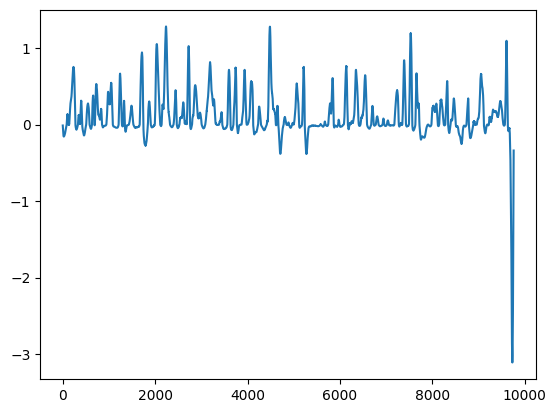

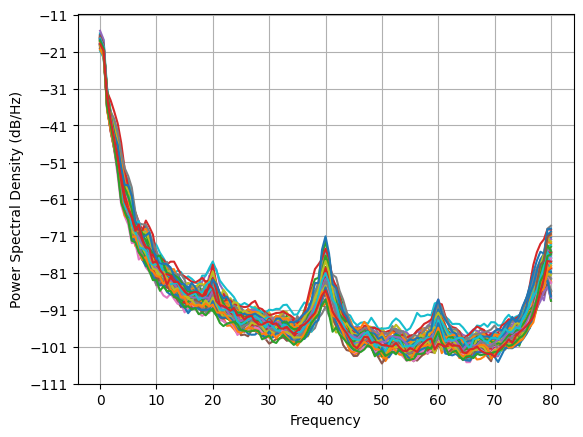

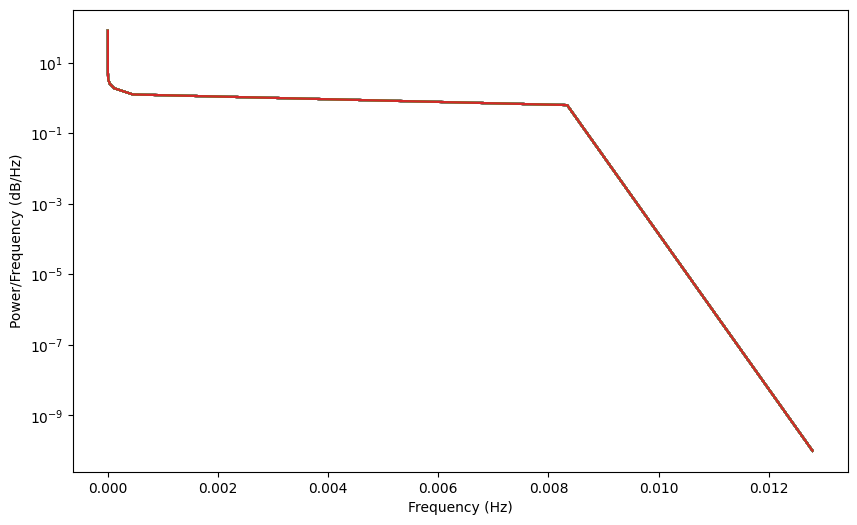

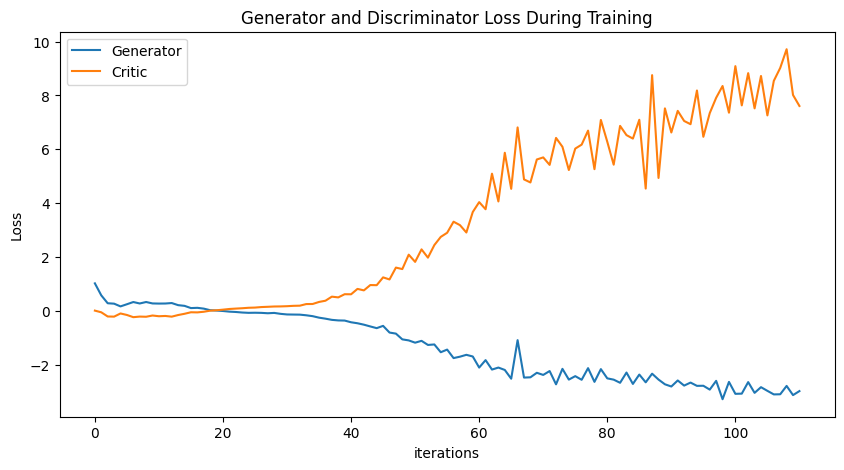

Epoch 120: Critic error ([1.021696020304355, 0.5751790099648636, 0.28241174729364693, 0.2671411554521002, 0.16571580514837497, 0.24568861597661698, 0.3278158144628937, 0.2741599461598232, 0.3287549453933505, 0.2755864759899904, 0.2705972449798348, 0.2729851596078793, 0.2900732391498444, 0.21192772622978023, 0.18585596222397838, 0.10299627371870293, 0.11265718278210908, 0.08287444210203201, 0.024252402105886806, 0.011330095416299715, -0.00525239867733697, -0.02905297038661378, -0.04174596744786184, -0.0617084636633795, -0.0736481869754706, -0.06987606024481585, -0.07489530999912447, -0.08887276613938691, -0.07662745968524705, -0.11120218262816847, -0.13357053300025334, -0.13752825256067444, -0.14061189603258686, -0.16444867069255342, -0.19728295204536384, -0.252883012515175, -0.2901617006441156, -0.33452732852185896, -0.3551721873182914, -0.36083041613811595, -0.42391723413793403, -0.4606565382901305, -0.5132359495855876, -0.5791282342751517, -0.6422781975985904, -0.5574482949995955, -0

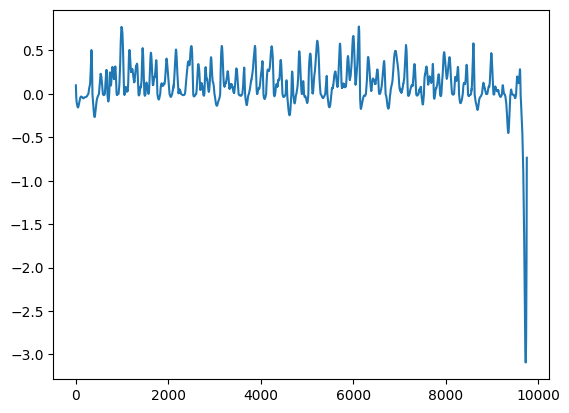

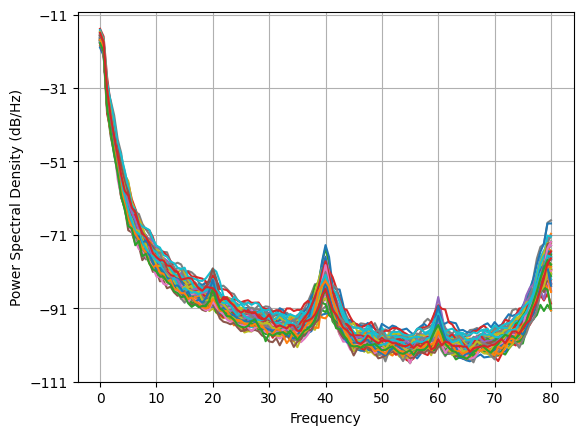

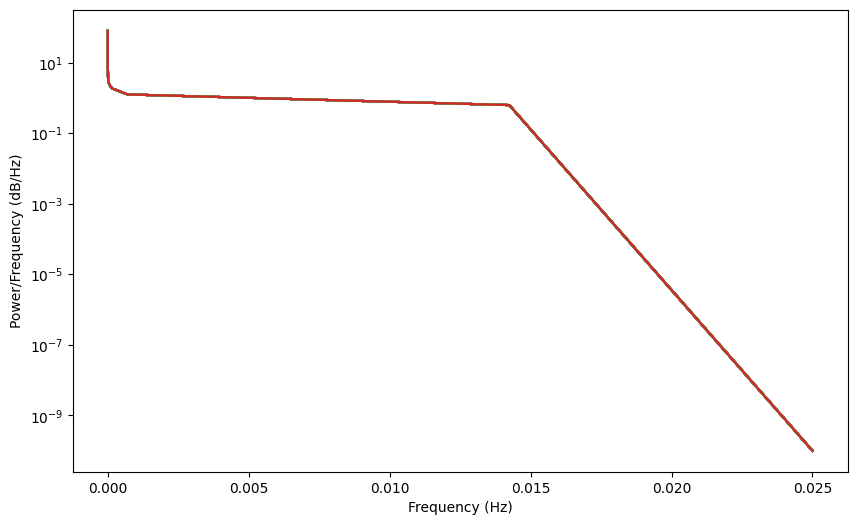

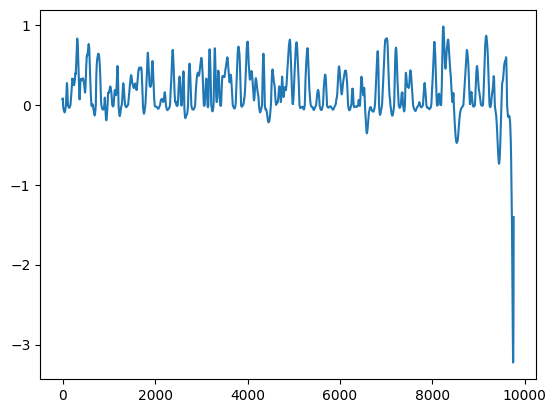

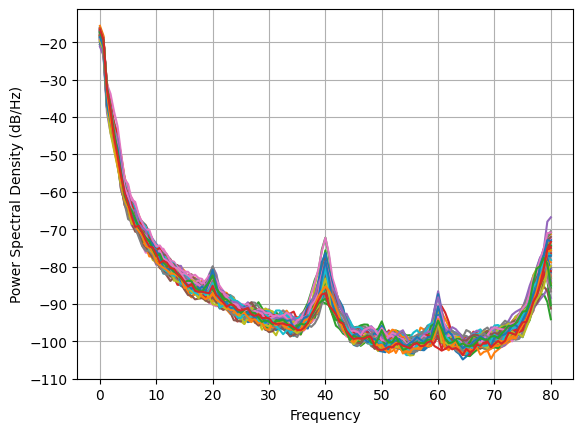

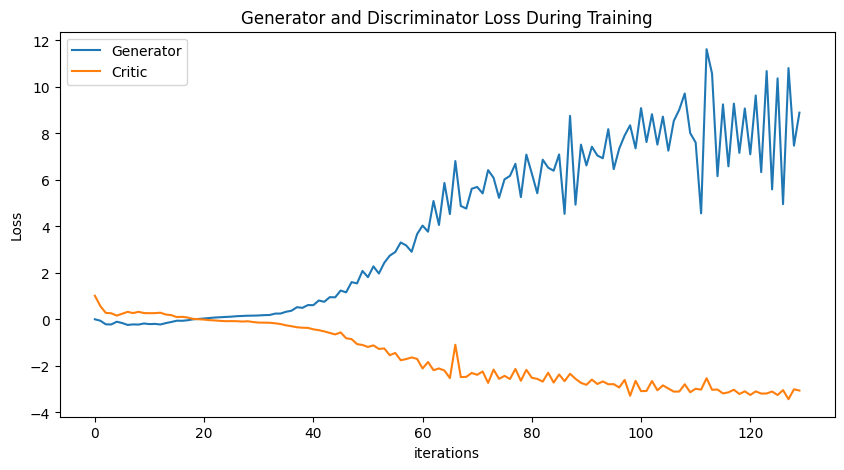

In [19]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 10
training_data = torch.tensor(np.load('training_open.npy'))
BATCH_SIZE = np.shape(training_data)[0]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            critic_real = D(real).reshape(-1)
            loss_critic_real = -torch.mean(critic_real)
            noise = sample_normal_distribution(BATCH_SIZE, 640, 305)
            fake = G(noise)
            critic_fake = D(fake).reshape(-1)
            loss_critic_fake = torch.mean(critic_fake)
            gp = gradient_penalty(D, real, fake) * LAMBDA_GP
            D.zero_grad()
            loss_critic = loss_critic_real + loss_critic_fake + gp
            loss_critic.backward()
            critic_optimizer.step()  

        noise = sample_normal_distribution(BATCH_SIZE, 640, 305)
        fake = G(noise)
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
        
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(fake, critic_err, gen_err)

    return critic_err, gen_err, fake, D, G
    return critic_err, gen_err, fake, D, G

critic_err, gen_err, generated_data_open, disc, gen = train()

critic_err, gen_err, generated_data_open, disc, gen = train()

torch.save(gen, 'generator_eyes_open.pt')
torch.save(disc, 'discriminator_eyes_open.pt')
np.save('640channels-open.npy', generated_data_open.detach())
plot_everything(generated_data_open, gen_err, critic_err)
generated_data_open = None

# Not complex

In [ ]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 10
training_data = torch.tensor(np.load('training_closed.npy'))
BATCH_SIZE = np.shape(training_data)[0]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            critic_real = D(real).reshape(-1)
            loss_critic_real = -torch.mean(critic_real)
            noise = sample_normal_distribution(BATCH_SIZE, 64, 305)
            fake = G(noise)
            critic_fake = D(fake).reshape(-1)
            loss_critic_fake = torch.mean(critic_fake)
            gp = gradient_penalty(D, real, fake) * LAMBDA_GP
            D.zero_grad()
            loss_critic = loss_critic_real + loss_critic_fake + gp
            loss_critic.backward()
            critic_optimizer.step()  

        noise = sample_normal_distribution(BATCH_SIZE, 64, 305)
        fake = G(noise)
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
        
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(fake, critic_err, gen_err)

    return critic_err, gen_err, fake, D, G

critic_err, gen_err, generated_data_closed, disc, gen = train()

torch.save(gen, 'generator1_eyes_closed.pt')
torch.save(disc, 'discriminator1_eyes_closed.pt')
np.save('64channels-closed.npy', generated_data_closed.detach())
plot_everything(generated_data_closed, gen_err, critic_err)
generated_data_closed = None

In [ ]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 10
training_data = torch.tensor(np.load('training_open.npy'))
BATCH_SIZE = np.shape(training_data)[0]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            critic_real = D(real).reshape(-1)
            loss_critic_real = -torch.mean(critic_real)
            noise = sample_normal_distribution(BATCH_SIZE, 640, 305)
            fake = G(noise)
            critic_fake = D(fake).reshape(-1)
            loss_critic_fake = torch.mean(critic_fake)
            gp = gradient_penalty(D, real, fake) * LAMBDA_GP
            D.zero_grad()
            loss_critic = loss_critic_real + loss_critic_fake + gp
            loss_critic.backward()
            critic_optimizer.step()  

        noise = sample_normal_distribution(BATCH_SIZE, 640, 305)
        fake = G(noise)
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
        
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(fake, critic_err, gen_err)

    return critic_err, gen_err, fake, D, G

critic_err, gen_err, generated_data_open, disc, gen = train()

torch.save(gen, 'generator1_eyes_open.pt')
torch.save(disc, 'discriminator1_eyes_open.pt')
np.save('64channels-open.npy', generated_data_open.detach())
plot_everything(generated_data_open, gen_err, critic_err)
generated_data_open = None

# inner channel size 64 * 11 or 64 * 12